## DNSC 6290: Responsible Machine Learning

#### Project notebook


#### Kaggle Contest: NYC Taxi Trip Duration
    
Contest link: 
    
https://www.kaggle.com/c/nyc-taxi-trip-duration/overview

### Because the dataset is too huge, a lot of ploting is done in another kernel working parallel and thus, a lot of plots cannot be displayed here.

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.max_columns = 999

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

from IPython.display import display, Image

import geopy.distance

import seaborn as sns

import datetime
import uszipcode

import xgboost
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

from joblib import dump, load

from xgboost import plot_importance

import math
import holidays

import shap
import collections

#### Read and view the data in a glance

In [3]:
train = pd.read_csv("C:\\Users\\lllll\\Desktop\\Responsible ml\\nyc-taxi-trip-duration\\train\\train.csv")

train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

In [74]:
print(train['pickup_datetime'].min())
print(train['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:39


In [5]:
max_trip = train['trip_duration'].max()
print("Longest trip in minutes: ",max_trip/60)

Longest trip in minutes:  58771.36666666667


The longest trip is 59k minutes which is not normal. Might be data error or driver(s) not taking trips while the trip sign is on.

Take a look at the target variable in detail.
Only look at trips shorter than 10k seconds.

(array([1.044399e+06, 3.297160e+05, 6.066800e+04, 1.556300e+04,
        4.524000e+03, 1.207000e+03, 2.970000e+02, 7.800000e+01,
        4.600000e+01, 2.300000e+01]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

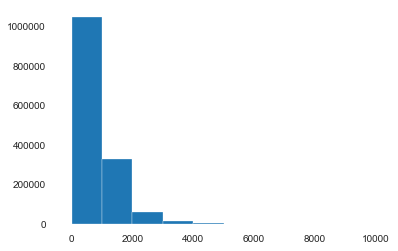

In [8]:
plt.hist(train['trip_duration'], range = [0, 10000])

Most of the trips are less than 5k seconds. We should be careful when dealing with extreme long trips because those observations might have negative impact on the model.

In [9]:
extreme_data = train[train.trip_duration >= 1e+4]['trip_duration'].count()
print("Number of extreme data: ", extreme_data)

Number of extreme data:  2123


There is only 2123 of trips longer than 10k compares to 1.5 million total data, we should look at those data and decide whether to keep or delete those data.

In [11]:
unique_extreme = train[train.trip_duration >= 1e+4]['trip_duration'].unique()
print("Number of unique extreme data: ", len(unique_extreme))

Number of unique extreme data:  1374


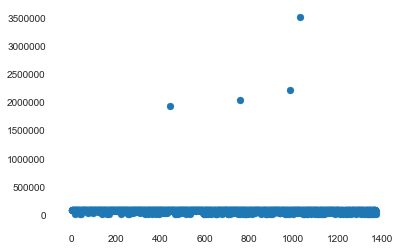

In [12]:
plt.scatter([i for i in range(len(unique_extreme))], unique_extreme)

We see that there are only 4 super extreme data which are longer than 2 million seconds.

In [13]:
train['trip_duration'].sort_values(ascending = False).head(-5)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
810851           1
767271           1
918415           1
35196            1
1439166          1
Name: trip_duration, Length: 1458639, dtype: int64

In [14]:
super_data_index = train['trip_duration'].sort_values(ascending = False).head(-4)[0:10].index.values

In [15]:
for i in super_data_index:
    print(train.iloc[i,])

id                              id0053347
vendor_id                               1
pickup_datetime       2016-02-13 22:46:52
dropoff_datetime      2016-03-25 18:18:14
passenger_count                         1
pickup_longitude                 -73.7839
pickup_latitude                   40.6486
dropoff_longitude                -73.9783
dropoff_latitude                  40.7502
store_and_fwd_flag                      N
trip_duration                     3526282
Name: 978383, dtype: object
id                              id1325766
vendor_id                               1
pickup_datetime       2016-01-05 06:14:15
dropoff_datetime      2016-01-31 01:01:07
passenger_count                         1
pickup_longitude                 -73.9838
pickup_latitude                   40.7423
dropoff_longitude                -73.9855
dropoff_latitude                  40.7277
store_and_fwd_flag                      N
trip_duration                     2227612
Name: 924150, dtype: object
id                  

We see that those trips have a common characteristic: longitude and latitude almost did not change. We can assume that those are not actual trips. The car was parked there while meter was on or something.

Need to come up with a threshold to find out all those outliers.

First try: if longitude and latitude did not change more than 1, and trip duration is greater than 50000 seconds, we can safely assume those are not actual trips.

In [16]:
train['delt_longitude'] = (train['pickup_longitude'] - train['dropoff_longitude']).abs()
train['delt_latitude'] = (train['pickup_latitude'] - train['dropoff_latitude']).abs()

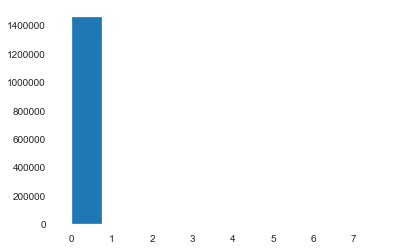

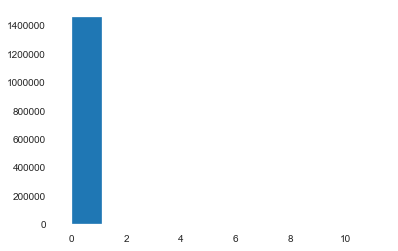

In [18]:
plt.hist(train['delt_longitude'])
plt.show()
plt.hist(train['delt_latitude'])
plt.show()

It is hard to set up a threshold for changes in longitude and latitude since they overlap a lot and some small changes do not mean short distance because of one-way or detour and etc...

First, remove those 4 super extreme data.

In [19]:
train = train.drop(train['trip_duration'].sort_values(ascending = False).head(-4)[0:4].index.values, axis = 0)
len(train)

1458640

Look at trips between 10k and 50k seconds.

In [20]:
test_long_duration = train[(train.trip_duration < 50000) & (train.trip_duration > 10000)]
test_long_duration

id  vendor_id      pickup_datetime     dropoff_datetime  \
13228    id3020268          2  2016-05-18 20:31:13  2016-05-19 00:00:00   
29062    id0025763          2  2016-04-24 13:38:15  2016-04-25 00:00:00   
31104    id0329738          2  2016-05-11 10:55:24  2016-05-11 14:23:24   
31355    id0309009          2  2016-04-26 12:18:22  2016-04-27 00:00:00   
34493    id0117857          1  2016-01-17 17:54:07  2016-01-17 21:51:30   
...            ...        ...                  ...                  ...   
1403697  id0509033          2  2016-02-02 09:06:24  2016-02-02 14:46:24   
1416336  id3795134          1  2016-03-21 20:54:00  2016-03-22 01:43:23   
1424543  id2214754          2  2016-05-15 15:22:02  2016-05-15 18:19:14   
1439125  id3886328          1  2016-05-14 15:09:32  2016-05-14 18:20:49   
1455042  id1352166          1  2016-06-03 07:20:58  2016-06-03 10:32:51   

         passenger_count  pickup_longitude  pickup_latitude  \
13228                  3        -73.872910        40.773956   
29062                  2        -73.782188        40.644619   
31104                  1        -73.781219        40.644951   
31355                  1        -73.978333        40.752384   
34493                  1        -73.982101        40.755665   
...                  ...               ...              ...   
1403697                1        -73.986107        40.760033   
1416336                3        -75.238327        39.923027   
1424543                1        -73.789452        40.647110   
1439125                1        -73.791389        40.646168   
1455042                5        -73.990211        40.747108   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
13228           -73.985214         40.735031                  N   
29062           -73.781830         40.644760                  N   
31104           -73.985085         40.762199                  N   
31355           -73.964569         40.767311                  N   
34493           -73.991684         40.764328                  N   
...                    ...               ...                ...   
1403697         -73.789276         40.646515                  N   
1416336         -73.922577         40.610130                  N   
1424543         -73.974274         40.748119                  N   
1439125         -73.987968         40.748741                  N   
1455042         -73.989983         40.746761                  N   

         trip_duration  delt_longitude  delt_latitude  
13228            12527        0.112305       0.038925  
29062            37305        0.000359       0.000141  
31104            12480        0.203865       0.117249  
31355            42098        0.013763       0.014927  
34493            14243        0.009583       0.008663  
...                ...             ...            ...  
1403697          20400        0.196831       0.113518  
1416336          17363        1.315750       0.687103  
1424543          10632        0.184822       0.101009  
1439125          11477        0.196579       0.102573  
1455042          11513        0.000229       0.000347  

[143 rows x 13 columns]

some trips ends at exactly 00:00:00, I think those are trips that drivers end their shift and they are not actually doing a trip during that time. Should delete them.

Make a copy of the dataframe in case we need the original data or we decide to recover some deleted data.

In [21]:
train1 = train.copy()

Use geopy to calculate geographical distance to assit in cleaning the data.

In [ ]:
def create_distance(data):
    
    data = list(data)
    
    x = geopy.distance.distance((data[0], data[1]), (data[2], data[3])).miles
    
    return x

train1['distance'] = list(map(create_distance, train1[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].values))

Data checkpoint 1.

In [23]:
train1.to_csv("C:\\Users\\lllll\\Desktop\\Responsible ml\\train1.csv", index = None)

Filter out all 00:00:00 ended trips.

In [24]:
dropoff_values = np.array(train1['dropoff_datetime'])

filters = lambda x: x[-8:]

dropoff_values_final = np.array([filters(n) for n in dropoff_values])
exact_index = np.array(np.where(dropoff_values_final == '00:00:00')).reshape(-1,).tolist()

In [25]:
exact_index_list = [i for i in exact_index]
zero_ended_data = train1.iloc[exact_index_list,]
zero_ended_data

id  vendor_id      pickup_datetime     dropoff_datetime  \
8401     id2799878          2  2016-04-13 22:31:24  2016-04-14 00:00:00   
13228    id3020268          2  2016-05-18 20:31:13  2016-05-19 00:00:00   
17173    id1873696          2  2016-04-10 23:40:20  2016-04-11 00:00:00   
20143    id1059394          2  2016-06-14 22:01:18  2016-06-15 00:00:00   
20153    id0463051          2  2016-02-02 01:45:11  2016-02-03 00:00:00   
...            ...        ...                  ...                  ...   
1401896  id2931945          2  2016-03-30 15:29:15  2016-03-31 00:00:00   
1414210  id3890858          2  2016-01-29 04:23:35  2016-01-30 00:00:00   
1425427  id3740626          2  2016-01-16 09:04:28  2016-01-17 00:00:00   
1433536  id1053733          2  2016-06-16 22:53:54  2016-06-17 00:00:00   
1455097  id2798196          2  2016-03-20 03:51:36  2016-03-21 00:00:00   

         passenger_count  pickup_longitude  pickup_latitude  \
8401                   2        -73.776764        40.645599   
13228                  3        -73.872910        40.773956   
17173                  1        -73.872864        40.774330   
20143                  2        -73.789864        40.647144   
20153                  1        -73.870842        40.773754   
...                  ...               ...              ...   
1401896                2        -73.789955        40.643471   
1414210                5        -73.962723        40.760609   
1425427                2        -73.958832        40.763870   
1433536                1        -73.970413        40.764565   
1455097                2        -73.969299        40.757301   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
8401            -74.011192         40.715530                  N   
13228           -73.985214         40.735031                  N   
17173           -73.900520         40.703892                  N   
20143           -73.790916         40.728577                  N   
20153           -73.971695         40.748768                  N   
...                    ...               ...                ...   
1401896         -73.853691         40.725021                  N   
1414210         -73.987541         40.737888                  N   
1425427         -73.989532         40.771873                  N   
1433536         -73.972099         40.765839                  N   
1455097         -73.870277         40.709808                  N   

         trip_duration  delt_longitude  delt_latitude   distance  
8401              5316        0.234428       0.069931  13.226336  
13228            12527        0.112305       0.038925   6.476179  
17173             1180        0.027657       0.070438   5.072550  
20143             7122        0.001053       0.081432   5.619263  
20153            80089        0.100853       0.024986   5.565290  
...                ...             ...            ...        ...  
1401896          30645        0.063736       0.081551   6.547771  
1414210          70585        0.024818       0.022720   2.038163  
1425427          53732        0.030701       0.008003   1.702670  
1433536           3966        0.001686       0.001274   0.124718  
1455097          72504        0.099022       0.047493   6.144460  

[224 rows x 14 columns]

(array([46., 16., 22., 29., 25., 12., 18., 22., 15., 19.]),
 array([2.90000e+01, 8.66510e+03, 1.73012e+04, 2.59373e+04, 3.45734e+04,
        4.32095e+04, 5.18456e+04, 6.04817e+04, 6.91178e+04, 7.77539e+04,
        8.63900e+04]),
 <a list of 10 Patch objects>)

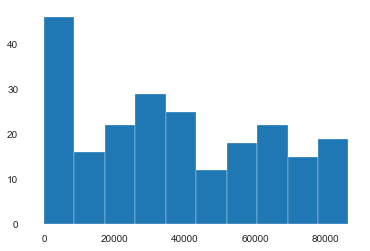

In [26]:
plt.hist(zero_ended_data['trip_duration'])

Some seems to be like normal data, some are really long trips. Look at hours greater than 20 hours first.

In [27]:
zero_ended_data[zero_ended_data.trip_duration >= 60*60*20]

id  vendor_id      pickup_datetime     dropoff_datetime  \
20153    id0463051          2  2016-02-02 01:45:11  2016-02-03 00:00:00   
26557    id0868351          2  2016-05-07 01:32:28  2016-05-08 00:00:00   
73816    id0953667          2  2016-05-06 00:00:10  2016-05-07 00:00:00   
149007   id2810921          2  2016-03-08 01:24:47  2016-03-09 00:00:00   
161855   id2522132          2  2016-06-01 02:28:47  2016-06-02 00:00:00   
178505   id0813088          2  2016-01-19 00:17:13  2016-01-20 00:00:00   
267242   id0930578          2  2016-04-02 02:33:22  2016-04-03 00:00:00   
295895   id0267173          2  2016-02-15 01:02:08  2016-02-16 00:00:00   
313759   id0804914          2  2016-04-21 01:40:39  2016-04-22 00:00:00   
577795   id0341817          2  2016-03-18 01:02:50  2016-03-19 00:00:00   
619863   id2549351          2  2016-03-17 00:05:26  2016-03-18 00:00:00   
709789   id1045209          2  2016-04-17 03:04:48  2016-04-18 00:00:00   
718961   id2275870          2  2016-01-16 02:31:15  2016-01-17 00:00:00   
783107   id2780568          2  2016-04-05 00:30:18  2016-04-06 00:00:00   
789131   id0071098          2  2016-06-12 02:53:55  2016-06-13 00:00:00   
803877   id1240412          2  2016-04-23 02:14:44  2016-04-24 00:00:00   
819609   id2096842          2  2016-03-27 00:28:37  2016-03-28 00:00:00   
945416   id2781344          2  2016-01-13 01:43:11  2016-01-14 00:00:00   
1041840  id3843914          2  2016-03-06 03:48:40  2016-03-07 00:00:00   
1049110  id0189779          2  2016-03-06 03:11:31  2016-03-07 00:00:00   
1139501  id3817233          2  2016-01-25 03:48:28  2016-01-26 00:00:00   
1186336  id1522937          2  2016-01-26 02:35:37  2016-01-27 00:00:00   
1191447  id1254681          2  2016-01-22 01:08:37  2016-01-23 00:00:00   
1204616  id3935810          2  2016-02-12 01:21:35  2016-02-13 00:00:00   
1205304  id3718595          2  2016-04-30 01:50:23  2016-05-01 00:00:00   
1220670  id1607985          2  2016-01-08 00:01:33  2016-01-09 00:00:00   
1239221  id2180713          2  2016-01-16 03:46:48  2016-01-17 00:00:00   
1279539  id0731077          2  2016-03-27 01:29:39  2016-03-28 00:00:00   
1326615  id2784900          2  2016-02-11 00:41:17  2016-02-12 00:00:00   
1455097  id2798196          2  2016-03-20 03:51:36  2016-03-21 00:00:00   

         passenger_count  pickup_longitude  pickup_latitude  \
20153                  1        -73.870842        40.773754   
26557                  1        -73.989883        40.725674   
73816                  1        -73.996010        40.753220   
149007                 2        -73.994370        40.724609   
161855                 1        -73.991051        40.685837   
178505                 2        -73.991264        40.770500   
267242                 5        -73.984161        40.738102   
295895                 2        -73.971390        40.794941   
313759                 1        -73.973701        40.756691   
577795                 1        -73.982231        40.764572   
619863                 1        -74.002014        40.745758   
709789                 1        -73.989151        40.718739   
718961                 6        -73.993881        40.741493   
783107                 2        -73.986954        40.764309   
789131                 5        -73.990181        40.718281   
803877                 2        -73.990341        40.735161   
819609                 1        -73.983078        40.693684   
945416                 1        -74.009460        40.738224   
1041840                1        -73.991310        40.755451   
1049110                1        -74.007835        40.715176   
1139501                1        -74.005928        40.743736   
1186336                4        -73.992111        40.742710   
1191447                1        -73.995087        40.719761   
1204616                1        -73.988411        40.746101   
1205304                6        -74.003487        40.732349   
1220670                2        -73.873123        40

These are definitely not real trips. The distance suggests that most of these trips are not valid trips.

All these data should be deteleted.

In [28]:
zeros_to_drop_index = zero_ended_data[zero_ended_data.trip_duration >= 60*60*20].index.values
len(zeros_to_drop_index)

30

In [29]:
train1 = train1.drop(zeros_to_drop_index, axis = 0)

Look at all trips that have a trip hours greater than 20 hours.

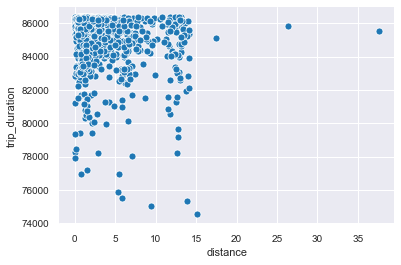

In [30]:
sns.set_style('darkgrid')
sns.scatterplot(x = train1[train1.trip_duration >= 60*60*20]['distance'], y = train1[train1.trip_duration >= 60*60*20]['trip_duration'])

We see a lot of trips have more than 80K seconds duration while the geographic distance are less than 10 miles. It is hard to believe that those are real trips. Therefore, we should delete trips with greater than 20 hours duration while have less than 10 miles of geographic distance.

In [31]:
drop_index_2 = train1[(train1.trip_duration >= 60*60*20) & (train1.distance <= 10)].index.values
len(drop_index_2)

1821

In [32]:
train1 = train1.drop(drop_index_2, axis = 0)
len(train1)

1456789

Look at all long duration trips again.

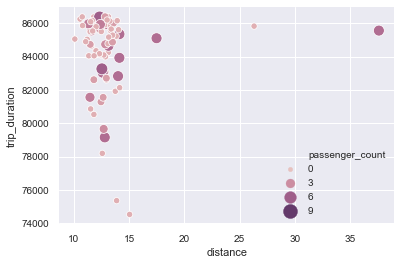

In [33]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x = train1[train1.trip_duration >= 60*60*20]['distance'], y = 'trip_duration', data = train1, hue = 'passenger_count', palette = cmap, size = 
               'passenger_count', sizes = (20, 200))

But there are a huge amount of trips that are around 10 to 15 miles and have durations greater than 82000 seconds which are longer than 22 hours. We should not include those observations. However, we can keep those long distance trips for now. 

In [34]:
drop_index_3 = train1[(train1.trip_duration >= 82000) & (train1.distance <= 25)].index.values
len(drop_index_3)

65

In [35]:
train1 = train1.drop(drop_index_3, axis = 0)

Look at the overall data trip_duration against distance.

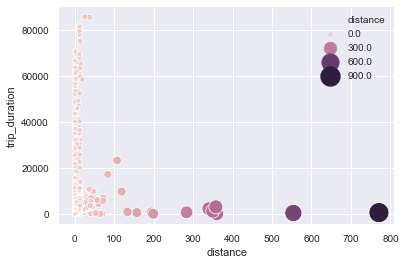

In [36]:
sns.scatterplot(x = 'distance', y = 'trip_duration', data = train1, hue = 'distance', size = 'distance', sizes = (20, 400))

Assume the average speed limit for NYC highway is 55 mph, we still see some trips with impossible long distances. There is no way such trips can be real. Set a speed threshold to clean some additional dirty data.

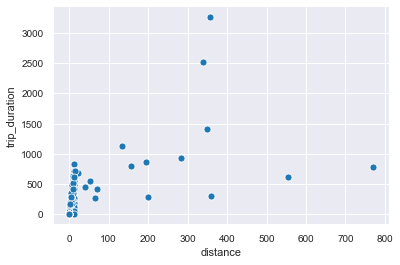

In [37]:
speed_threshold = 55
sns.scatterplot(x = train1[train1.distance / train1.trip_duration * 60 * 60 >= speed_threshold]['distance'], 
                y = 'trip_duration', data = train1)

Most of those data are for sure not real trips. Might be GPS error? No idea, but should delete them. However, before doing so, should look at those data that have around 0 distance.

The black line represent a speed of 80 mph
The blue line represent a speed of 55 mph
Points below the black line means the speed is greater than 80 mph


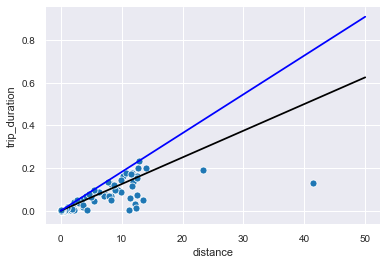

In [38]:
sns.set_style('darkgrid')
scatter = sns.scatterplot(x = train1[(train1.distance / train1.trip_duration * 60 * 60 >= speed_threshold) 
                                     & (train1.distance <= 50)]['distance'], 
                          y = train1['trip_duration']/3600, 
                          data = train1)
scatter.plot()
plt.plot([0,50], [0,50/80], c = 'black')
plt.plot([0,50], [0, 50/55], c = 'b')
print("The black line represent a speed of 80 mph")
print("The blue line represent a speed of 55 mph")
print('Points below the black line means the speed is greater than 80 mph')

Clearly all those data have an average speed greater than 55 GEOGRAPHIC MPH. That's not trustworthy. Even some of them might be real (driving on road like NJ Turnpike when there is no traffic and the real distance between the pickup and dropoff locations are close to the geographic distance), since we are predicting NYC trips, those data are still misleading. Therefore, we should delete them.

Since most trips are inside Manhattan, speed greater than 40 mph should be consider invalid.

In [39]:
speed_threshold = 40
drop_index_4 = train1[(train1.distance / train1.trip_duration * 60 * 60 >= speed_threshold)].index.values
len(drop_index_4)

462

In [40]:
train1 = train1.drop(drop_index_4, axis = 0)

Now take a look at the distribution of trip_duration again

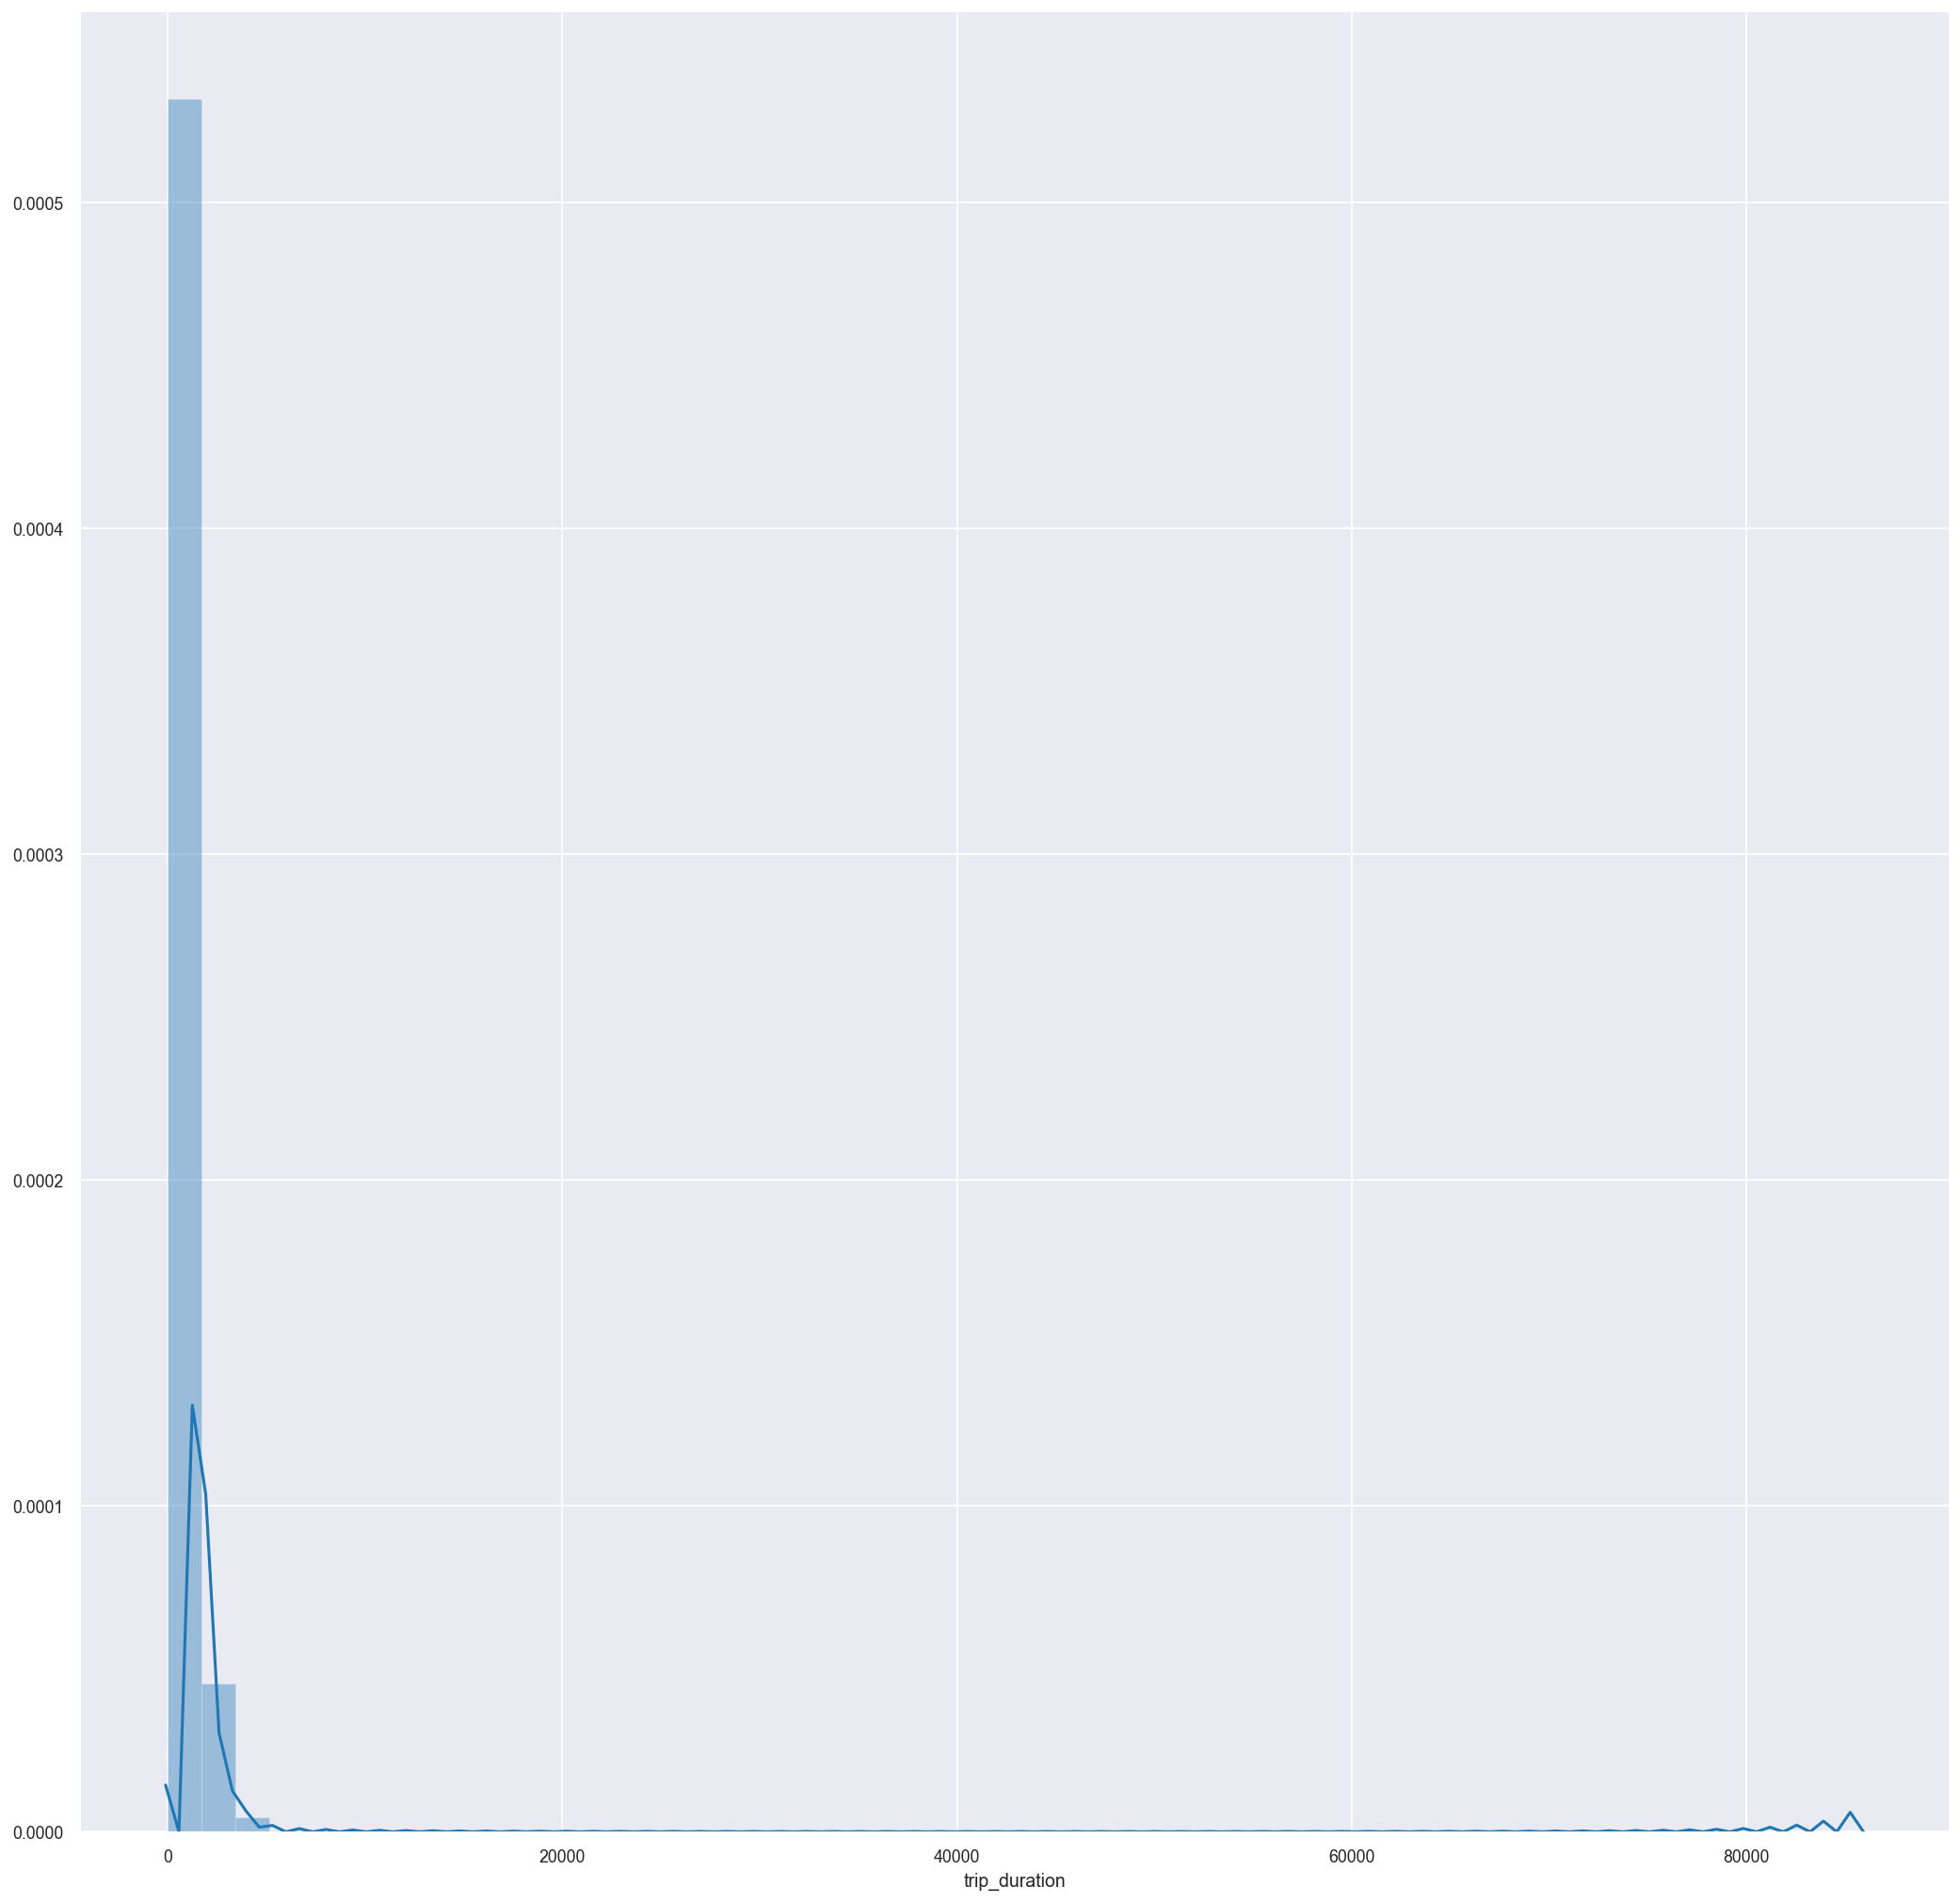

In [41]:
plt.figure(dpi = 128, figsize = (20, 20))
sns.distplot(train1['trip_duration'])

There are still some spikes at greater than 70k seconds. Take a close look again.

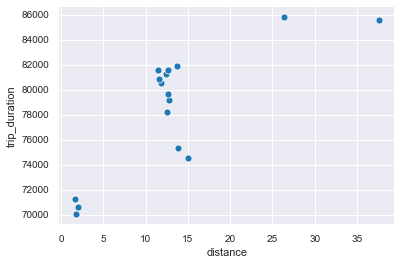

In [42]:
sns.scatterplot(x = train1[train1.trip_duration >= 70000]['distance'], y = 'trip_duration', data = train1)

for now, assume distance <= 20 miles are invalid. Drop them.

In [43]:
drop_index_5 = train1[(train1.trip_duration >= 70000) & (train1.distance <= 20)].index.values
len(drop_index_5)

14

In [44]:
train1 = train1.drop(drop_index_5, axis = 0)

When we look at the speed of some trips, we found that some trips have extremely short duration. First let's look at duration less than 60 seconds.

The red line represent a speed of 25 mph
The blue line represent a speed of 36 mph
The black line represent a speed of 55 mph


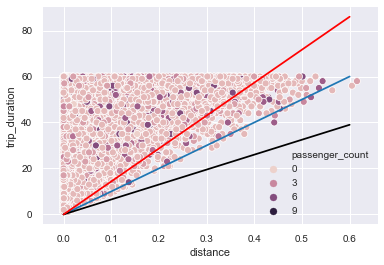

In [45]:
sns.scatterplot(x = train1[train1.trip_duration <= 60]['distance'], y = 'trip_duration', data = train1, hue = 'passenger_count')
plt.plot([0, 0.6], [0, 60])
plt.plot([0, 0.6], [0, 39], c = 'black')
plt.plot([0, 0.6], [0, 86], c = 'r')
print('The red line represent a speed of 25 mph')
print('The blue line represent a speed of 36 mph')
print('The black line represent a speed of 55 mph')

Since stop-n-go and acceleration take times, trips that are shorter than 60 seconds with speed greater than 25 geographic mph is impossible. We should delete those data

In [46]:
drop_index_6 = train1[(train1.trip_duration <= 60) & (train1.distance / train1.trip_duration * 60 * 60 >= 25)].index.values
len(drop_index_6)

389

In [47]:
train1 = train1.drop(drop_index_6, axis = 0)

Those short trips can be considered as passengers regreting about taking a cab. Check trips shorter than 40 seconds. 

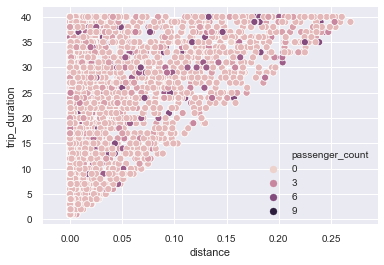

In [48]:
sns.scatterplot(x = train1[train1.trip_duration <= 40]['distance'], y = 'trip_duration', data = train1, hue = 'passenger_count')

I still don't believe someone can drive more than 0.2 miles in less than 40 seconds. Should drop those data. Plus, there are a lot of trips took less than 20 seconds. I don't think those data are useful since those are obviously non-usual trips. Should delete them as well.

In [49]:
drop_index_7 = train1[(train1.trip_duration <= 40) & (train1.distance >= 0.2)].index.values
drop_index_8 = train1[train1.trip_duration <= 20].index.values
print(len(drop_index_7),len(drop_index_8))

79 3345


In [50]:
train1 = train1.drop(drop_index_7, axis = 0)
train1 = train1.drop(drop_index_8, axis = 0)

Finally, look at the average speed to find other outliers (non-trips).

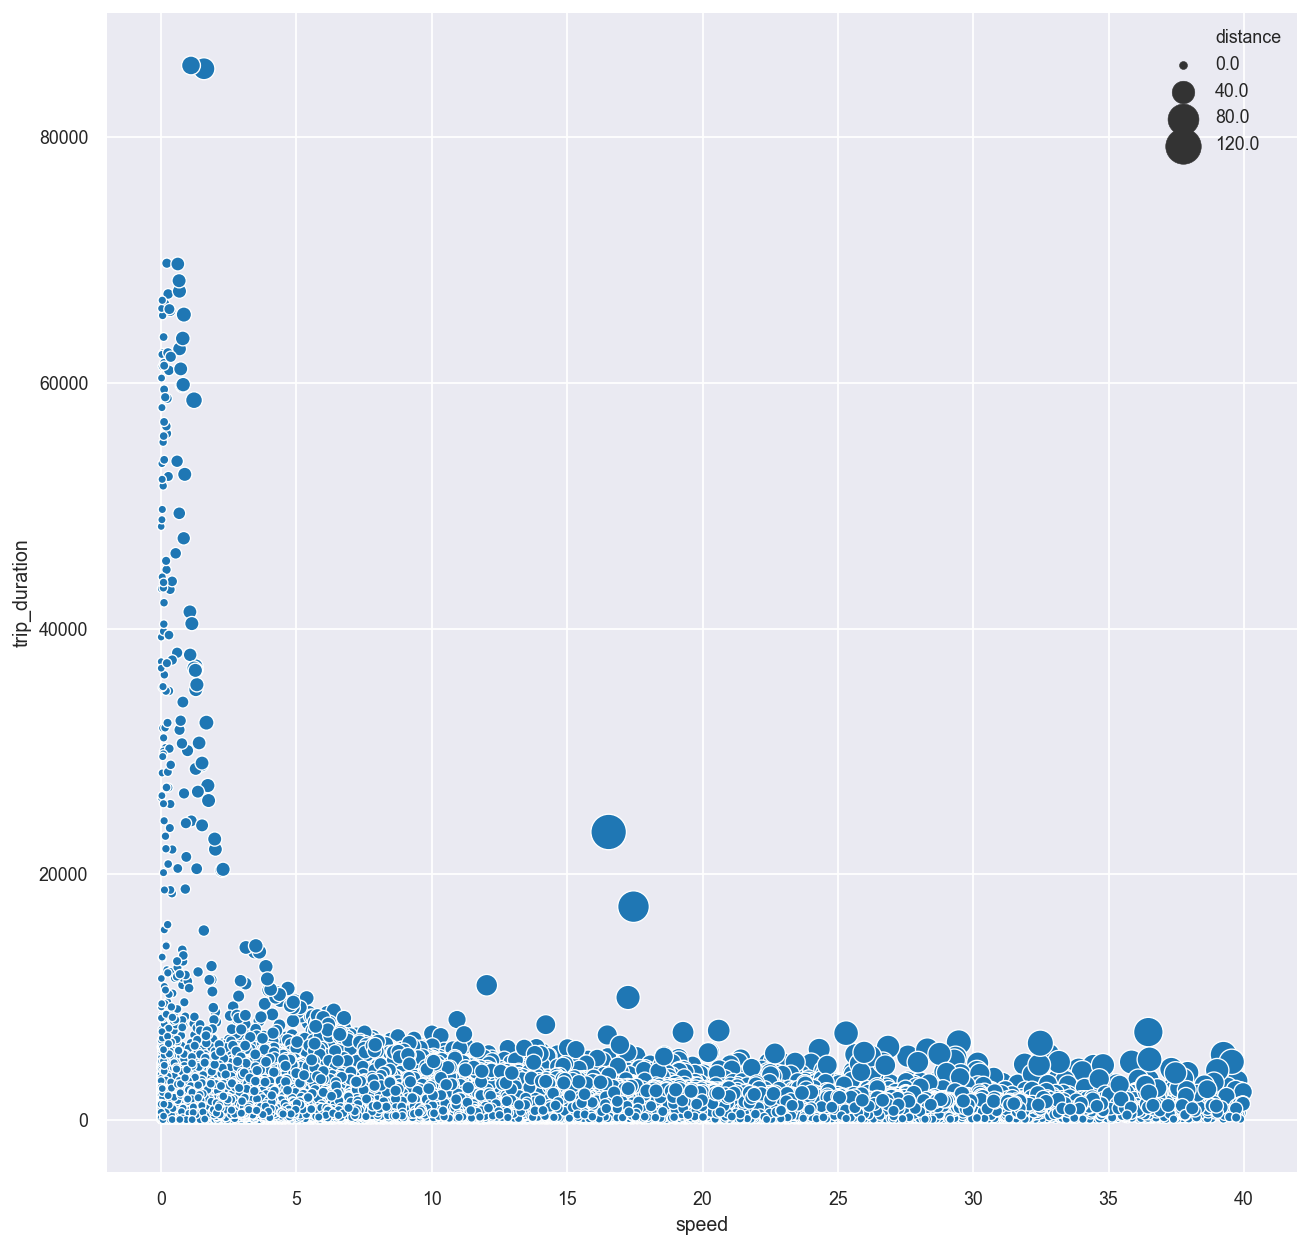

In [51]:
train1['speed'] = train1['distance'] / train1['trip_duration'] * 3600

plt.figure(dpi = 128, figsize = (12,12))
sns.scatterplot(x = 'speed', y = 'trip_duration', data = train1, size = 'distance', sizes = (20, 400))

There are a lot of trips that last longer than 20k seconds while having a speed of less than 1 miles. Though they might be real trips (maybe someone pay the cabie to wait there or roadblocked), still meaningless data for most usual trips. Drop them.

In [52]:
drop_index_9 = train1[(train1.speed <= 1) & (train1.trip_duration >= 20000)].index.values
len(drop_index_9)

106

In [53]:
train1 = train1.drop(drop_index_9, axis = 0)

That should cleaned most of the invalid trips. Now look at if there is any trips with 0 passenger.

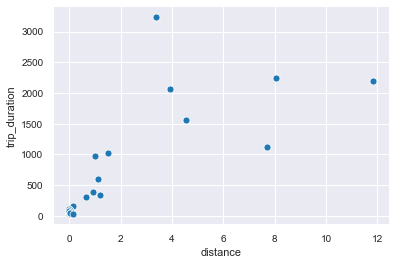

In [54]:
sns.scatterplot(x = train1[train1.passenger_count == 0]['distance'], y = 'trip_duration', data = train1)

Those trips look valid. Just leave it as 0.

The trip duration to airports (JFK, LGA, EWR) might have a different behavior. Create features (miles to airport from pickup, miles to airpot from dropoff) to find out if that's true.

Collect airports geographic location data.

In [56]:
airport_geo = {'jfk':[40.6413111, -73.7781391], 'lga': [40.7730135746,  -73.8702298524], 'ewr':[40.6895314, -74.17446239999998]}

In [62]:
airport_list = ['jfk','lga','ewr']
for i in airport_list:
    
    airport = i
    
    print("Working on airport {}".format(i))
    
    lag_long_pickup = np.array(train1[['pickup_latitude','pickup_longitude']].values).tolist()
    lag_long_dropoff = np.array(train1[['dropoff_latitude','dropoff_longitude']].values).tolist()

    pick_up_distance = [geopy.distance.distance((lag_long_pickup[n][0],lag_long_pickup[n][1]), (airport_geo[str(airport)][0],airport_geo[str(airport)][1])).miles for n in range(len(lag_long_pickup))]
    
    drop_off_distance = [geopy.distance.distance((lag_long_dropoff[n][0],lag_long_dropoff[n][1]), (airport_geo[str(airport)][0],airport_geo[str(airport)][1])).miles for n in range(len(lag_long_pickup))]
    
    if (len(pick_up_distance) == len(drop_off_distance)) & (len(pick_up_distance) == len(lag_long_pickup)):
        print('Successful {}, appending columns to dataframe'.format(i))
    
    train1['{}_miles_pickup'.format(i)] = pick_up_distance
    train1['{}_miles_dropoff'.format(i)] = drop_off_distance

Working on airport jfk
Successful jfk, appending columns to dataframe
Working on airport lga
Successful lga, appending columns to dataframe
Working on airport ewr
Successful ewr, appending columns to dataframe


In [63]:
train1

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458639         -73.994911         40.740170                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration  delt_longitude  delt_latitude  distance      speed  \
0                  455        0.017525       0.002335  0.933406   7.385193   
1                  663        0.019066       0.007412  1.123849   6.102349   
2                 2124        0.026306       0.053852  3.964154   6.718905   
3                  429        0.002228       0.013252  0.921886   7.736110   
4                  435        0.000130       0.010689  0.737591   6.104201   
...                ...             ...            ...       ...        ...   
1458639            778        0.012711       0.005352  0.762478   3.528176   
1458640            655        0.030762       0.049168  3.756942  20.648841   
1458641            764        0.045303       0.061428  4.860075  22.900875   
1458642            373        0.007446       0.008045  0.678863   6.552028   
1458643            198        0.006729       0.008835  0.704421  12.807650   

         jfk_miles_pickup  jfk_miles_dropoff  lga_miles_pickup  \
0               13.824483          13.017665          5.882039   
1               12.566088          13.175735          6.251233   
2               13.523534          12.844377          5.741917   
3               13.336371          13.102038          8.199357   
4               14.648523          14.125844          5.570226   
...                   ...                ...               ...   
1458639         12.906206          13.272553          6.173668   
1458640         13.802127          14.710390          7.082868   
1458641         12.950

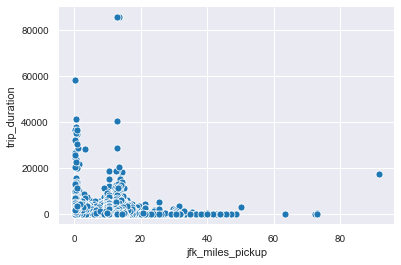

In [67]:
sns.scatterplot(train1[train1.jfk_miles_pickup <= 100]['jfk_miles_pickup'], y = 'trip_duration', data = train1)

We can see that trips around jfk pickup, and trips where the pickup location are 15 miles away from jfk, usually have longer duration. Might due to: Going from jfk to Manhattan cost a long time (NYC traffic is the best); 15 miles away from JFK is probably Manhattan thus terrific traffic.

Same pattern can be found on other two airports, graph is not displayed here.

Checkpoint 2

In [69]:
train1.to_csv("C:\\Users\\lllll\\Desktop\\Responsible ml\\cleaned_with_airport.csv", index = None)

Create some day and month categorical data since it is reasonable to assume that traffic has relationships with time.

First, creates date feature without hours and minutes for future merge with external data.

In [221]:
train1['date'] = None
date_values = np.array(train1['pickup_datetime'])

filters = lambda x: x[0:10]

date_values_final = np.array([filters(n) for n in date_values])

In [222]:
len(date_values_final)
date_values_final

array(['2016-03-14', '2016-06-12', '2016-01-19', ..., '2016-04-22',
       '2016-01-05', '2016-04-05'], dtype='<U10')

In [223]:
train1['date'] = date_values_final

Create hour feature.

In [103]:
hour_values = np.array(train1['pickup_datetime'])

filters = lambda x: x[11:13]

hour_values_final = np.array([filters(n) for n in hour_values])

train1['hour'] = hour_values_final

Workday feature. Use datetime module to automatically label days.

In [119]:
import datetime
def get_day(data):
    
    day_fun = lambda x: datetime.datetime.strptime(x[0:10], '%Y-%m-%d').weekday()  
    
    day_values_final = np.array([day_fun(n) for n in data])
    
    train1['day'] = day_values_final
    
    return train1

if __name__ == '__main__':
    get_day(train1['pickup_datetime'])

0 represent Monday;
1 represent Tuesday;
2 represent Wednesday;
...
6 represent Sunday.

In [120]:
train1

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458639         -73.994911         40.740170                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration  delt_longitude  delt_latitude  distance      speed  \
0                  455        0.017525       0.002335  0.933406   7.385193   
1                  663        0.019066       0.007412  1.123849   6.102349   
2                 2124        0.026306       0.053852  3.964154   6.718905   
3                  429        0.002228       0.013252  0.921886   7.736110   
4                  435        0.000130       0.010689  0.737591   6.104201   
...                ...             ...            ...       ...        ...   
1458639            778        0.012711       0.005352  0.762478   3.528176   
1458640            655        0.030762       0.049168  3.756942  20.648841   
1458641            764        0.045303       0.061428  4.860075  22.900875   
1458642            373        0.007446       0.008045  0.678863   6.552028   
1458643            198        0.006729       0.008835  0.704421  12.807650   

         jfk_miles_pickup  jfk_miles_dropoff  lga_miles_pickup  \
0               13.824483          13.017665          5.882039   
1               12.566088          13.175735          6.251233   
2               13.523534          12.844377          5.741917   
3               13.336371          13.102038          8.199357   
4               14.648523          14.125844          5.570226   
...                   ...                ...               ...   
1458639         12.906206          13.272553          6.173668   
1458640         13.802127          14.710390          7.082868   
1458641         12.950

Weather might also affect traffic. This weather data set comes from:

https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016

by

Mathijs Waegemakers.

In [213]:
weather = pd.read_csv("C:\\Users\\lllll\\Desktop\\nyc_weather.csv")
weather

date  maximum temperature  minimum temperature  \
0      1-1-2016                   42                   34   
1      2-1-2016                   40                   32   
2      3-1-2016                   45                   35   
3      4-1-2016                   36                   14   
4      5-1-2016                   29                   11   
..          ...                  ...                  ...   
361  27-12-2016                   60                   40   
362  28-12-2016                   40                   34   
363  29-12-2016                   46                   33   
364  30-12-2016                   40                   33   
365  31-12-2016                   44                   31   

     average temperature precipitation snow fall snow depth  
0                   38.0          0.00       0.0          0  
1                   36.0          0.00       0.0          0  
2                   40.0          0.00       0.0          0  
3                   25.0          0.00       0.0          0  
4                   20.0          0.00       0.0          0  
..                   ...           ...       ...        ...  
361                 50.0             0         0          0  
362                 37.0             0         0          0  
363                 39.5          0.39         0          0  
364                 36.5          0.01         T          0  
365                 37.5             0         0          0  

[366 rows x 7 columns]

Weather data uses 'T' to represent: There is snow/rain but too small to be precisely measured. Thus, convert 'T' into a small number.

In [214]:
def T_converter(x):
    if x == 'T':
        x = 0.001
    return x

for i in weather.columns.values:
    weather[i] = list(map(T_converter, weather[i]))

In [215]:
weather

date  maximum temperature  minimum temperature  \
0      1-1-2016                   42                   34   
1      2-1-2016                   40                   32   
2      3-1-2016                   45                   35   
3      4-1-2016                   36                   14   
4      5-1-2016                   29                   11   
..          ...                  ...                  ...   
361  27-12-2016                   60                   40   
362  28-12-2016                   40                   34   
363  29-12-2016                   46                   33   
364  30-12-2016                   40                   33   
365  31-12-2016                   44                   31   

     average temperature precipitation snow fall snow depth  
0                   38.0          0.00       0.0          0  
1                   36.0          0.00       0.0          0  
2                   40.0          0.00       0.0          0  
3                   25.0          0.00       0.0          0  
4                   20.0          0.00       0.0          0  
..                   ...           ...       ...        ...  
361                 50.0             0         0          0  
362                 37.0             0         0          0  
363                 39.5          0.39         0          0  
364                 36.5          0.01     0.001          0  
365                 37.5             0         0          0  

[366 rows x 7 columns]

Convert the date column into the same format in our training data.

In [217]:
date_converted = []
def date_converter(data):
    weather_date = np.array(data['date'])
    date_converter = lambda x: datetime.datetime.strptime(x, '%d-%m-%Y')
    date_temp = [date_converter(n).strftime('%Y-%m-%d') for n in weather_date]
    data['Date'] = date_temp
    return data

if __name__ == '__main__':
    date_converter(weather)

Merge the weather data with the training data.

In [224]:
train1 = train1.merge(weather, left_on = 'date', right_on = 'Date', how = 'left')

In [225]:
train1

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1452324  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1452325  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1452326  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1452327  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1452328  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1452324                4        -73.982201        40.745522   
1452325                1        -74.000946        40.747379   
1452326                1        -73.959129        40.768799   
1452327                1        -73.982079        40.749062   
1452328                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1452324         -73.994911         40.740170                  N   
1452325         -73.970184         40.796547                  N   
1452326         -74.004433         40.707371                  N   
1452327         -73.974632         40.757107                  N   
1452328         -73.972809         40.790585                  N   

         trip_duration  delt_longitude  delt_latitude  distance      speed  \
0                  455        0.017525       0.002335  0.933406   7.385193   
1                  663        0.019066       0.007412  1.123849   6.102349   
2                 2124        0.026306       0.053852  3.964154   6.718905   
3                  429        0.002228       0.013252  0.921886   7.736110   
4                  435        0.000130       0.010689  0.737591   6.104201   
...                ...             ...            ...       ...        ...   
1452324            778        0.012711       0.005352  0.762478   3.528176   
1452325            655        0.030762       0.049168  3.756942  20.648841   
1452326            764        0.045303       0.061428  4.860075  22.900875   
1452327            373        0.007446       0.008045  0.678863   6.552028   
1452328            198        0.006729       0.008835  0.704421  12.807650   

         jfk_miles_pickup  jfk_miles_dropoff  lga_miles_pickup  \
0               13.824483          13.017665          5.882039   
1               12.566088          13.175735          6.251233   
2               13.523534          12.844377          5.741917   
3               13.336371          13.102038          8.199357   
4               14.648523          14.125844          5.570226   
...                   ...                ...               ...   
1452324         12.906206          13.272553          6.173668   
1452325         13.802127          14.710390          7.082868   
1452326         12.950

Clean all extra columns created by pandas during merge. I did not specify this command during merge because I found this is easier can clearer to do so.

In [226]:
train1 = train1.drop(['date_y', 'Date'], axis = 1)
train1 = train1.rename(columns = {'date_x':'date'})

In [228]:
train1

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1452324  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1452325  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1452326  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1452327  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1452328  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1452324                4        -73.982201        40.745522   
1452325                1        -74.000946        40.747379   
1452326                1        -73.959129        40.768799   
1452327                1        -73.982079        40.749062   
1452328                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1452324         -73.994911         40.740170                  N   
1452325         -73.970184         40.796547                  N   
1452326         -74.004433         40.707371                  N   
1452327         -73.974632         40.757107                  N   
1452328         -73.972809         40.790585                  N   

         trip_duration  delt_longitude  delt_latitude  distance      speed  \
0                  455        0.017525       0.002335  0.933406   7.385193   
1                  663        0.019066       0.007412  1.123849   6.102349   
2                 2124        0.026306       0.053852  3.964154   6.718905   
3                  429        0.002228       0.013252  0.921886   7.736110   
4                  435        0.000130       0.010689  0.737591   6.104201   
...                ...             ...            ...       ...        ...   
1452324            778        0.012711       0.005352  0.762478   3.528176   
1452325            655        0.030762       0.049168  3.756942  20.648841   
1452326            764        0.045303       0.061428  4.860075  22.900875   
1452327            373        0.007446       0.008045  0.678863   6.552028   
1452328            198        0.006729       0.008835  0.704421  12.807650   

         jfk_miles_pickup  jfk_miles_dropoff  lga_miles_pickup  \
0               13.824483          13.017665          5.882039   
1               12.566088          13.175735          6.251233   
2               13.523534          12.844377          5.741917   
3               13.336371          13.102038          8.199357   
4               14.648523          14.125844          5.570226   
...                   ...                ...               ...   
1452324         12.906206          13.272553          6.173668   
1452325         13.802127          14.710390          7.082868   
1452326         12.950

Checkpoint 3.

In [232]:
train1.to_csv("C:\\Users\\lllll\\Desktop\\Responsible ml\\date_weather_added.csv", index = None)
weather.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\modified_weather.csv', index = None)

In [2]:
train1 = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\date_weather_added.csv')

Create another copy.

In [3]:
train2 = train1.copy()

Create month data as well.

In [5]:
month = lambda x: x[5:7]
month_array = np.array([month(n) for n in np.array(train2['pickup_datetime'])])
month_array

array(['03', '06', '01', ..., '04', '01', '04'], dtype='<U2')

In [6]:
train2['month'] = month_array

Create categorical features: airport trip. 1 if pickup or dropoff inside 1.5 miles range from the airport. 

In [7]:
def airport_trip():
    
    for i in ['jfk','lga','ewr']:
        
        temp_data = np.array(train2[['{}_miles_pickup'.format(i), '{}_miles_dropoff'.format(i)]].values)
        
        airport_filter = lambda x: 1 if (x[0] <= 1.5) or (x[1] <= 1.5) else 0
        
        airport_trip_cat = [airport_filter(n) for n in temp_data]
        
        train2['{}_trip'.format(i)] = airport_trip_cat
        
if __name__ == '__main__':
    airport_trip()

Create features identifing pickup and dropoff borough use uszpicode module

In [9]:
def create_borough_bound(nyc_zipcode_file):

    import uszipcode
    import pandas as pd
    import numpy as np
    import geopy

    search = uszipcode.SearchEngine(simple_zipcode = True) # Initiate Zipcode search engine

    zipcode_raw = pd.read_excel('C:\\Users\\lllll\\Desktop\\Responsible ml\\nyc_zipcode.xlsx')  # NYC borough/neighborhood zipcode data

    zip_borough = {}  #Split zipcodes into single key

    for i in zipcode_raw['Borough'].unique().tolist():

        temp_data = zipcode_raw[zipcode_raw.Borough == i]

        for n in temp_data['ZIP Codes']:

            data = str(n).split(',')

            for zips in data:
                temp_geo = search.by_zipcode(zips).values()[-4:]
                zip_borough[zips] = [i]
    
    
    """
    For some reasons this search cannot be done inside an array otherwise only the first zipcode will be returned.
    Thus need to append longitude and latitude values seperately.
    
    """

    for i in zip_borough:  
        zip_borough[i].append(search.by_zipcode(int(i)).values()[-4:])
    
    """
    Create a temporary pd dataframe to filter boroughs' bound.
    """

    zips = []
    boroughs = []
    lag_upper = []
    lag_lower = []
    long_left = []
    long_right = []
    
    
    for i in zip_borough:
        zips.append(i)
        boroughs.append(zip_borough[i][0])
        long_left.append(zip_borough[i][1][0])
        long_right.append(zip_borough[i][1][1])
        lag_upper.append(zip_borough[i][1][2])
        lag_lower.append(zip_borough[i][1][3])

    zipcode_bound = pd.DataFrame(data = {'Zipcode':zips,'Borough':boroughs,'Upper_lagitude':lag_upper,'Lower_lagitude':lag_lower,'Left_longitude':long_left,'Right_longitude':long_right})
    
    
    """
    Create a csv file containing each borough's boudns. These codes are beta codes thus not the most efficient codes.
    """
    
    
    upper = []
    lower = []
    left = []
    right = []
    temp_borough = []

    for i in zipcode_raw['Borough'].unique().tolist():
        temp_borough.append(i)
        upper.append(zipcode_bound[zipcode_bound.Borough == i]['Upper_lagitude'].max())
        lower.append(zipcode_bound[zipcode_bound.Borough == i]['Upper_lagitude'].min())
        left.append(zipcode_bound[zipcode_bound.Borough == i]['Left_longitude'].min())
        right.append(zipcode_bound[zipcode_bound.Borough == i]['Right_longitude'].max())

    borough_bound = pd.DataFrame(data = {'Borough':temp_borough,'Upper_lag':upper,'Lower_lag':lower,'Left_long':left,'Right_long':right})
    
    borough_bound.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\Borough_bound.csv', index = None)

In [354]:
bound = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\Borough_bound.csv')

In [355]:
bound

Borough  Upper_lag  Lower_lag  Left_long  Right_long
0          Bronx  40.915282  40.813731 -73.933406  -73.764661
1       Brooklyn  40.739446  40.584575 -74.042492  -73.855660
2      Manhattan  40.877650  40.709044 -74.047285  -73.910587
3         Queens  40.800888  40.576215 -73.962795  -73.700837
4  Staten Island  40.649468  40.520732 -74.255895  -74.051416

In [11]:
def bound(data):
    
    data = list(data)
    
    if ((float(data[0]) <= 40.877650) 
    & (float(data[0]) >= 40.709044)
    & (float(data[1]) >= -74.047285)
    & (float(data[1]) <= -73.910587)):
        
        x = 'Manhattan'
    
    elif ((float(data[0]) <= 40.800888)
    & (float(data[0]) >= 40.576215)
    & (float(data[1]) >= -73.962795)
    & (float(data[1]) <= -73.700837)):
        
        x = 'Queens'
    
    elif ((float(data[0]) <= 40.739446)
    & (float(data[0]) >= 40.584575)
    & (float(data[1]) >= -74.042492)
    & (float(data[1]) <= -73.855660)):
        
        x = 'Brooklyn'
    
    elif ((float(data[0]) <= 40.915282)
    & (float(data[0]) >= 40.813731)
    & (float(data[1]) >= -73.933406)
    & (float(data[1]) <= -73.764661)):
        
        x = 'Bronx'
    
    elif ((float(data[0]) <= 40.649468)
    & (float(data[0]) >= 40.520732)
    & (float(data[1]) >= -74.255895)
    & (float(data[1]) <= -74.051416)):
        
        x = 'Staten Island'
    
    else:
        
        x = 'Outside NYC'
   
    return x

In [12]:
train2['Pickup_borough'] = list(map(bound, train2[['pickup_latitude','pickup_longitude']].values))
train2['Dropoff_borough'] = list(map(bound, train2[['dropoff_latitude','dropoff_longitude']].values))

Traffic in Manhattan also have different pattern, use a distance from the Central Park to try to capture them.

In [14]:
def central_park_distance(data):
    
    data = list(data)
    
    x = geopy.distance.distance((data[0], data[1]), (40.785091, -73.968285)).miles
    
    return x

train2['cp_distance_pickup'] = list(map(central_park_distance, train2[['pickup_latitude', 'pickup_longitude']].values))
train2['cp_distance_dropoff'] = list(map(central_park_distance, train2[['dropoff_latitude', 'dropoff_longitude']].values))

Save new data again.

In [26]:
train2.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\newest_train_beta1.csv', index = None)

In [2]:
train2 = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\newest_train_beta1.csv')

<h3>Combine OSRM api route data and additional detailed weather data</h3>


Another copy for checkpoint

In [4]:
train3 = train2.copy()

Add detailed weather data.

In [6]:
knyc = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\KNYC_Metars.csv')

date_filter = lambda x: x[0:10]
knyc_date = [date_filter(n) for n in knyc['Time'].values]
knyc['Date'] = knyc_date

year_filter = lambda x: x[0:4]
knyc_year = [year_filter(n) for n in knyc['Time'].values]
knyc['Year'] = knyc_year

knyc = knyc[knyc.Year == '2016']

time_filter = lambda x: str(x[0:13])+':00:00'
train3_time = [time_filter(n) for n in train3['pickup_datetime'].values]
train3_dropofftime = [time_filter(n) for n in train3['dropoff_datetime'].values]

train3['pickup_time'] = train3_time
train3['dropoff_time'] = train3_dropofftime

train3 = train3.merge(knyc, left_on = 'pickup_time', right_on = 'Time', how = 'left')

train3 = train3.drop(['pickup_time','dropoff_time','Time','Year','Date'], axis = 1)

try1 = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\combined+table+with+neighborhood+and+boro+information.csv')
try1 = try1[['id','pickup_boro','pickup_neighborhood_name','pickup_neighborhood_code','dropoff_neighborhood_name','dropoff_neighborhood_code']]

train3 = train3.merge(try1, on = 'id', how = 'left')

weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']  # Dates with extreme weather reported by NYC city

weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date

train3['extreme_weather'] = train3.date.isin(weather_event).map({True: 1, False: 0})

train3

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cat_cols = ['Events','Conditions','pickup_neighborhood_code','dropoff_neighborhood_code']

for i in cat_cols:
    print(i)
    
    train3[i] = train3[i].astype(str)
    
    train3['cat_{}'.format(i)] = le.fit_transform(train3[i])
    
train3



In [13]:
del knyc

In [17]:
del try1

Replace space with _ for column names.

In [47]:
modify_list = ['maximum temperature','minimum temperature','average temperature','snow fall','snow depth']
modified_dic = {}
def modified_weather(data):
    
    for i in data.columns.values:
        
        if i in modify_list:
            
            modified_dic[i] = str(i).split(' ')[0] + '_' + str(i).split(' ')[1]
            
        else:
            modified_dic[i] = i
            
    data = data.rename(columns = modified_dic)
    return data
    
train3 = modified_weather(train3)

Create categorical data identifying trips direction borough-wise.

In [21]:
def going_to_manhattan(data):
    
    data = list(data)
    
    if (data[0] != 'Manhattan') & (data[1] == 'Manhattan'):
        
        x = 'To Manhattan'
        
    elif (data[1] != 'Manhattan') & (data[0] == 'Manhattan'):
        
        x = 'Out Manhattan'
        
    elif (data[1] != 'Outside NYC') & (data[0] == 'Outside NYC') & (data[1] != 'Manhattan'):
        
        x = 'Goin NYC not Manhattan'
    
    elif (data[1] == 'Manhattan') & (data[0] == 'Outside NYC'):
        
        x = 'Goin NYC Manhattan'
    
    elif (data[1] == 'Manhattan') & (data[0] == 'Manhattan'):
        
        x = 'Inside Manhattan'
    
    else:
        
        x = 'Not Manhattan'
        
    return x

train3['from_to'] = list(map(going_to_manhattan, train3[['Pickup_borough','Dropoff_borough']].values))

Create holiday feature using holidays module.

In [22]:
def get_holidays(data):
    
    #data = list(data)

    us_holidays = holidays.UnitedStates()
    
    x = us_holidays.get(data)
    
    return x

train3['holiday'] = list(map(get_holidays, train3['date'].values))

Label rush hour.

In [23]:
def get_rushhour(data):
    
    if data in range(6,10):
        x = 'morning_rush'
        
    elif data in range(15, 21):
        x = 'eve_rush'
    
    else:
        x = 'not_rush'
    
    return x

train3['rush_hour'] = list(map(get_rushhour, train3['hour'].values))

Create one-hot data for xgboost because one-hot performs better than normal encoding in xgboost.

In [4]:
def create_onehot(categorical, data):
 
    for cat in categorical:
        
        columns_index = {}
        temp = pd.get_dummies(data[cat])
    
        for i in temp.columns.values:

            if (cat == 'Pickup_borough') or (cat == 'Dropoff_borough'):
                columns_index[i] = '{}_{}'.format(cat[0:-8], i)
            
            else:
                columns_index[i] = '{}_{}'.format(cat, i)
                
        temp = temp.rename(columns = columns_index)
        
        data = data.merge(temp, how = 'left', left_index = True, right_index = True)
    
    return data

categorical_list = ['vendor_id','store_and_fwd_flag','workday','month','Pickup_borough','Dropoff_borough','Holiday','rush_hour','airport_pickup','airport_dropoff','Events','Conditions', 'extreme_weather']

train3 = create_onehot(categorical_list, train3)

My computer's memory is 16Gb but still cannot handle one-hot encoded neighborhood name (150+ unique values). Tree model should be still able to find some pattern even if this is not one-hot encoded. 

In [5]:
le = LabelEncoder()
for i in ['pickup_neighborhood_name','dropoff_neighborhood_name']:
    
    temp = train3[i]
    train3['cat_{}'.format(i)] = le.fit_transform(temp)

#### Add api calculated real distance and step directions fastest route.

In [ ]:
route_api = pd.concat([pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\fastest_routes_train_part_1.csv'),pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\fastest_routes_train_part_2.csv')])
route_api['total_distance'] = route_api['total_distance'] / 1000 / 1.6  # Convert meters to miles

Add routing movements summary for each trip's possible fastest route.

In [204]:
def get_left_turns(data):
        
    x = data.split('|').count('left') + data.split('|').count('slight left') + data.split('|').count('sharp left')
    
    return x

def get_right_turns(data):
    
    
    x = data.split('|').count('right') + data.split('|').count('slight right') + data.split('|').count('sharp right')
    
    return x

def get_straight_turns(data):
    
    
    x = data.split('|').count('straight')
    
    return x

def get_onramp(data):
    
    x = data.split('|').count('on ramp')
    return x

def get_offramp(data):
    
    x = data.split('|').count('off ramp')
    return x

def get_fork(data):
    
    x = data.split('|').count('fork')
    return x

def get_endofroad(data):
    
    x = data.split('|').count('end of road')
    return x

def get_continue(data):
    
    x = data.split('|').count('continue')
    return x

def get_roundabout(data):
    
    x = data.split('|').count('roundabout')
    return x

def get_rotary(data):
    
    x = data.split('|').count('rotary')
    return x

def get_roundaboutturn(data):
    
    x = data.split('|').count('roundabout turn')
    return x

In [199]:
route_api['on_ramps'] = list(map(get_onramp, route_api['step_maneuvers']))
route_api['off_ramps'] = list(map(get_offramp, route_api['step_maneuvers']))
route_api['forks'] = list(map(get_fork, route_api['step_maneuvers']))
route_api['end_roads'] = list(map(get_endofroad, route_api['step_maneuvers']))
route_api['continue'] = list(map(get_continue, route_api['step_maneuvers']))
route_api['roundabout'] = list(map(get_roundabout, route_api['step_maneuvers']))
route_api['rotary'] = list(map(get_rotary, route_api['step_maneuvers']))
route_api['roundaboutturn'] = list(map(get_roundaboutturn, route_api['step_maneuvers']))

route_api['left_turns'] = list(map(get_left_turns, route_api['step_direction']))
route_api['right_turns'] = list(map(get_right_turns, route_api['step_direction']))
route_api['straight_turns'] = list(map(get_straight_turns, route_api['step_direction']))

In [209]:
route_api_final = route_api.copy()

Only merge useful features from the route_api data.

In [212]:
route_api_final = route_api_final[['id','total_distance','total_travel_time','number_of_steps','left_turns',
                                   'right_turns','straight_turns','on_ramps','off_ramps','forks','end_roads','continue'
                                   ,'roundabout','rotary','roundaboutturn']]

route_api_final

id  total_distance  total_travel_time  number_of_steps  \
0       id2875421        1.255688              164.9                5   
1       id2377394        1.570750              332.0                6   
2       id3504673        1.112125              235.8                4   
3       id2181028        1.009312              140.1                5   
4       id0801584        0.870937              189.4                5   
...           ...             ...                ...              ...   
758638  id2976426       17.531937             1462.5               13   
758639  id1440046       18.510187             1643.2               16   
758640  id1607338       16.009375             1765.1               30   
758641  id2071901       12.677562             1074.3               14   
758642  id0995846       18.939062             1675.8               20   

        left_turns  right_turns  straight_turns  on_ramps  off_ramps  forks  \
0                1            1               2         0          0      0   
1                2            2               0         0          0      0   
2                2            1               0         0          0      0   
3                2            2               0         0          0      0   
4                1            3               0         0          0      0   
...            ...          ...             ...       ...        ...    ...   
758638           2            7               3         1          1      3   
758639           4            7               4         1          2      2   
758640           7           13               8         2          2      5   
758641           5            5               3         1          2      3   
758642           6            9               4         1          2      5   

        end_roads  continue  roundabout  rotary  roundaboutturn  
0               0         0           0       1               0  
1               1         1           0       0               0  
2               1         0           0       0               0  
3               0         0           0       0               0  
4               0         0           0       0               0  
...           ...       ...         ...     ...             ...  
758638          0         0           0       0               0  
758639          0         0           0       0               0  
758640          1         1           0       0               0  
758641          0         0           0       0               0  
758642          1         0           0       1               0  

[1458643 rows x 15 columns]

In [213]:
train3 = train3.merge(route_api_final, on = 'id', how = 'left')

In [218]:
del route_api_final

#### Create training and testing data for model.

Fill nan for these categorical features.

In [43]:
for i in train3.columns.values:
    
    if train3[i].isnull().values.any():
        print(i, train3[i].isnull().values.sum())
        
for i in ['Events','Conditions']:
    
    train3[i] = train3[i].fillna('None')
    
train3 = train3.dropna(how = 'any', axis = 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
for i in train3.columns.values:
    
    if train3[i].isnull().values.any():
        print(i, train3[i].isnull().values.sum())
        
for i in ['Events','Conditions']:
    
    train3[i] = train3[i].fillna('None')
    
train3 = train3.dropna(how = 'any', axis = 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
categorical = ['vendor_id','store_and_fwd_flag','month','Pickup_borough','Dropoff_borough',
               'rush_hour','Events','Conditions', 
               'holiday','pickup_neighborhood_name','dropoff_neighborhood_name','pickup_neighborhood_code',
              'dropoff_neighborhood_code','from_to','cat_pickup_neighborhood_code','cat_dropoff_neighborhood_code','day']

train_feature_list = []

"""
Use remove here for manual feature selection
"""

X = [i for i in train3.columns.values]
#X.remove('id')
X.remove('trip_duration')
X.remove('speed')
#X.remove('delt_longitude')
#X.remove('delt_latitude')
X.remove('distance')
X.remove('pickup_datetime')
X.remove('dropoff_datetime')
X.remove('date')
X.remove('Temp.')
X.remove('Windchill')
X.remove('Wind Dir')
X.remove('Precip')
X.remove('pickup_boro')
X.remove('pickup_latitude')
X.remove('pickup_longitude')
X.remove('dropoff_latitude')
X.remove('dropoff_longitude')
X.remove('total_travel_time')
X.remove('cat_pickup_neighborhood_name')
X.remove('cat_dropoff_neighborhood_name')

for i in categorical:
    X.remove(i)
y = 'trip_duration'
X

train_feature_list = X

GB tree does not require data scaling, thus create training and validation set directly.

In [66]:
X, y = train3[train_feature_list], train3[y]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

validation = test_X
validation['trip_duration'] = test_y

train_X, test_X = train_X.drop(['id'], axis = 1), test_X.drop(['id'], axis = 1)

In [31]:
train_feature_list.remove('id')

validation here is for model intepretation.

Checkpoint 4

In [69]:
validation.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\validation_for_ICE.csv', index = None)

In [45]:
train3.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\newest_train_beta2.csv', index = None)

In [28]:
del train3

In [26]:
train3 = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\newest_train_beta2.csv', encoding = 'ISO-8859-1')

### <br>
<br>
<h2>Model building and training.</h2>

### A lot of models were tested tunned, below is the best model with tunned parameters.

<h3>gpu xgboost with modified parameters.</h3>

<h4>Do not run if xgboost version is not 1.0.0<br>xgboost 1.1.0 output model format is not compatible with shap module.<br>Have to use 1.0.0 xgboost.</h4>

In [351]:
xgboost.__version__

'1.0.0'

Old params for original xgboost module. Not for sckit-learn wrapped xgboost model.

This variable is for storage use. Not for model use.

Parameters below arrived by randomized search. Search codes and outputs are deleted to save space.

Do not run if cuda and cudnn are not installed. GPU xgb model. Only support NVIDIA and requires cuda >= 9.0 plus cudnn.

In [8]:
params = {'tree_method':'gpu_hist', 'reg_lambda':0.8, 'reg_alpha':0.8,
         'colsample_bytree':0.7, 'subsample':1, 'min_child_weight':10, 'max_depth':13, 'learning_rate':0.07,
         'verbosity':2, 'eval_metric':'rmse', 'seed':0 }

In [8]:
gpu_xgb_model = xgboost.XGBRegressor(gpu_id = 0, tree_method = 'gpu_hist', reg_lambda = 0.8, reg_alpha = 0.8,
                            colsample_bytree = 0.7, n_estimators = 5000, max_depth = 13, learning_rate = 0.07,
                            verbosity = 2, booster = 'gbtree', min_child_weight = 10, subsample = 1, random_state = 0,
                            num_parallel_tree = 1)

Use early_stopping_rounds and eval_metric to prevent overfitting and reduce computation time.

In [ ]:
gpu_xgb_model.fit(train_X, train_y, eval_metric = 'rmse', eval_set = [(test_X, test_y, 'validation')],
                 early_stopping_rounds = 500, verbose = True)

#### The model performance:
    
Test RMSE of 288.91968.

This code can convert xgboost 1.1.0 original model (xgboost.train) output to shap module compatible format but DMatrix is not friendly to use. Thus omitted. Code is saved for future use.

In [ ]:
# Only run this for xgboost 1.1.0 dmatrix input

#model_bytearray = gpu_xgb_model.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

#gpu_xgb_model.save_raw = myfun

<br>

<br>

## Model Interpretation

#### Take a look at feature importances first before going to model interpretation.

In [ ]:
feature_imp_dict = {}
imp_list = gpu_xgb_model.feature_importances_

for i in range(len(train_feature_list)):
    feature_imp_dict[train_feature_list[i]] = imp_list[i]

In [ ]:
test_fea_dic = feature_imp_dict.copy()
sorted_test = sorted(test_fea_dic.items(), key = lambda kv: kv[1], reverse = True)
sorted_importance_list = collections.OrderedDict(sorted_test)

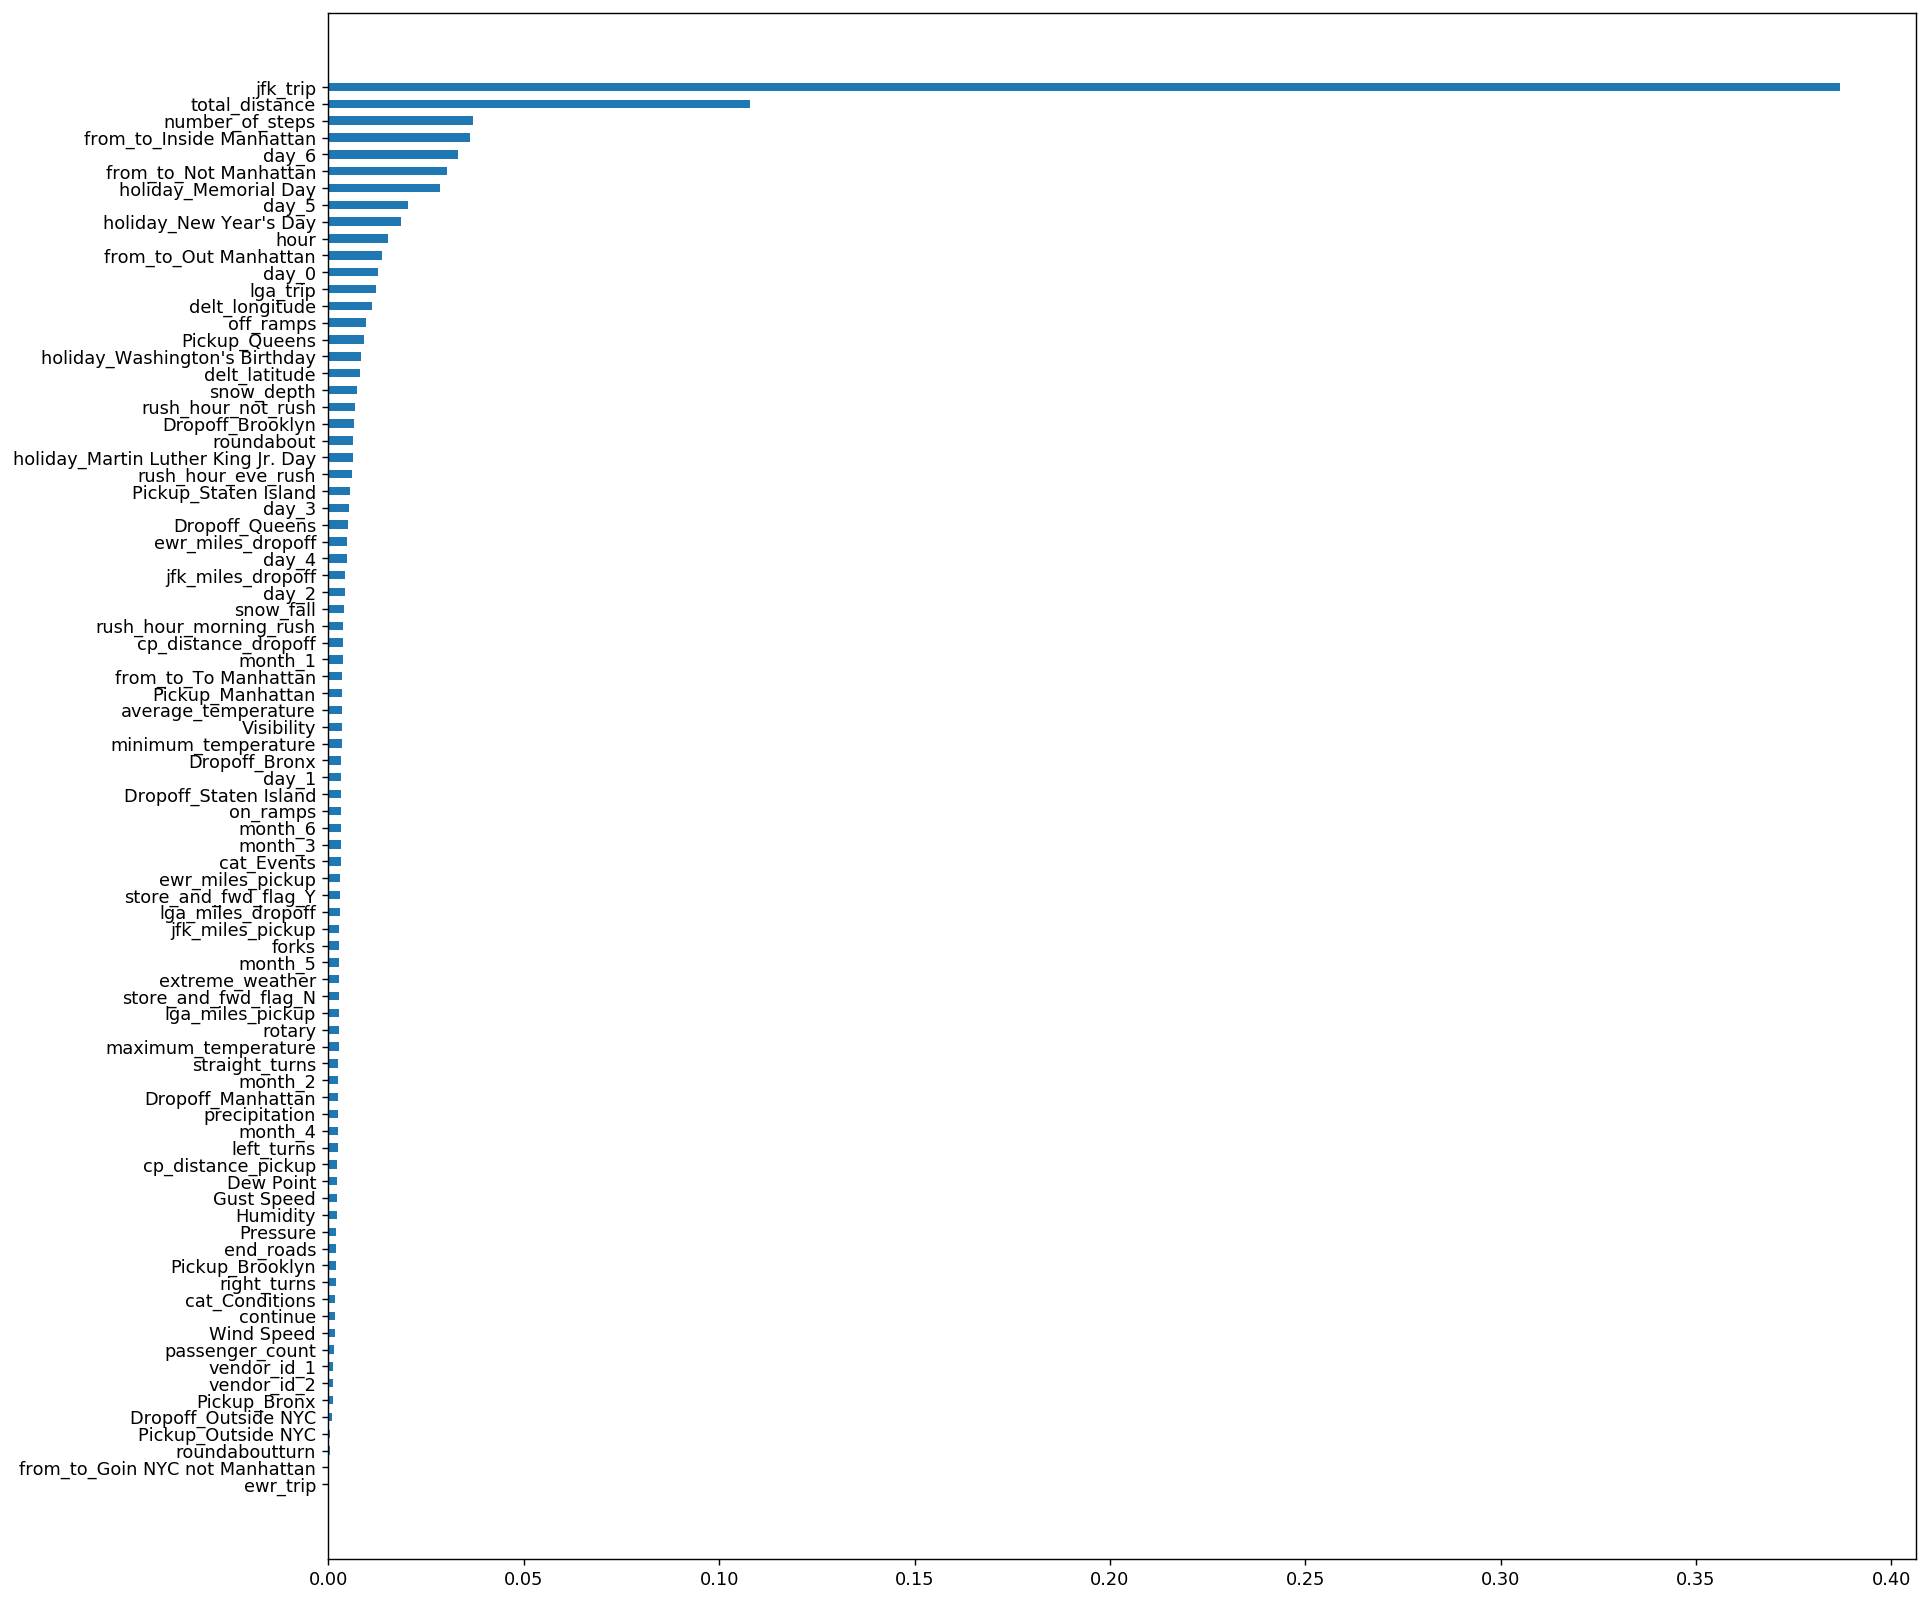

In [69]:
plt.figure(dpi = 128, figsize = (16,16))
plt.barh([i for i in sorted_importance_list.keys()][::-1], [i for i in sorted_importance_list.values()][::-1], height = 0.5,
        tick_label = [i for i in sorted_importance_list.keys()][::-1])
plt.yticks(np.arange(len([i for i in sorted_importance_list.keys()][::-1])))
plt.show()

As we can see from the plot of feature importance, the features that affect the most are trip to JFK airpots,totla trip distance, number of steps, trips on weekend, trips to manhantten. It is quite reseasonble to get why there those features are important.

#### Calculate partial dependence and ICE for selected features.

In [76]:
validation_data = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\validation_for_ICE.csv')

In [142]:
def test_ICE(feature, data, model, feature_list, resolution = 20, bins = None):
    
    pd.options.mode.chained_assignment = None
    
    par_dep_frame = pd.DataFrame(columns = [feature, 'partial_dependence'])
    col_cache = data.loc[:, feature].copy(deep=True)
    
    if bins is None:

        min_ = data[feature].min()
        max_ = data[feature].max()
        by = (max_ - min_) / resolution
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))  # bins calculation from referenced author

    for j, _ in enumerate(bins):
        
        if j + 1 <= len(bins):
            data.loc[:, feature] = bins[j]  # Not using j+1 because this dataset contains too many extreme data points on the upper side.
            par_dep_i = pd.DataFrame(model.predict(data[feature_list]))
            par_dep_j = par_dep_i.mean()[0]
            par_dep_frame = par_dep_frame.append({feature:bins[j],'partial_dependence': par_dep_j}, ignore_index=True)
    
   
    data.loc[:, feature] = col_cache   

    return par_dep_frame
    
    

Since there is not specific observations interested in, we simply look at data at each 10th percentile of trip_duration.

In [79]:
def get_percentile(prediction, data, id_):
    
    data_sorted = data.copy(deep = True)
    data_sorted = data_sorted.sort_values(prediction)
    data_sorted = data_sorted.reset_index()
    
    percentile_dict = {0: data_sorted.loc[0, id_], 99: data_sorted.loc[int(data.shape[0] - 1), id_]}
    
    inc = data_sorted.shape[0] // 10
    
    for i in range(1, 10):
        percentile_dict[i * 10] = data_sorted.loc[i * inc, id_]
        
    return percentile_dict
    

Get percentile first.

In [80]:
xgb_per_dict = get_percentile('prediction_1', validation_data, 'id')

Select some high importances features to compute.

In [7]:
features_to_plot = ['jfk_miles_dropoff','ewr_miles_dropoff','ewr_miles_pickup','jfk_miles_pickup','cp_distance_dropoff','hour','delt_longitude','total_distance','day_3','number_of_steps','day_0','day_6','day_2','day_5']

Compute ICE and partial dependence for selected features.

<b>Computational heavy codes.

In [ ]:
ice_dict = {}
for i in features_to_plot:
    #print('Working on feature: ', i)
    ice_dict[i] = test_ICE(i, validation_data, gpu_xgb_model, train_feature_list)

In [ ]:
for i in features_to_plot:
    
    bins = list(ice_dict[i][i])
    print('Working on features: ', i)
    
    for j in sorted(xgb_per_dict.keys()):
        col_name = 'Percentile_{}'.format(j)
        ice_dict[i][col_name] = test_ICE(i, validation_data[validation_data['id'] == str(xgb_per_dict[j])], gpu_xgb_model, train_feature_list, bins = bins)['partial_dependence']

save the dictionary because it takes too long to compute.

In [347]:
test_ice_df = pd.DataFrame()
for i in ice_dict.keys():
    for n in ice_dict[i].keys():
        if n != str(i):
            test_ice_df['{}_{}'.format(i, n)] = ice_dict[i][n]
        
        else:
            test_ice_df[n] = ice_dict[i][n]



test_ice_df.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\ice_values_selected.csv', index = None)

<h4>Visualize ICE and Partial Dependence</h4>

In [349]:
def plot_pd_ice(x_name, par_dep_frame, ax=None):
    
    """
    The ax parameters is not really needed, but keep it here just in case want to plot categorical feature with extremly high
    cardinality.
    
    If not none, need to modify the second function to group bins.
    For now this is disabled because we are not plotting high cardinality data.
    """
    
    if ax is None:

        fig, ax = plt.subplots()

        par_dep_frame.drop('partial_dependence', axis=1).plot(x=x_name,
                                                              colormap='gnuplot',
                                                              ax=ax)
        
        par_dep_frame.plot(title = 'Partial Dependence with ICE: ' + x_name,
                           x=x_name,
                           y='partial_dependence',
                           color='grey',
                           linewidth=2,
                           ax=ax)
        
    else:

        par_dep_frame.drop('partial_dependence', axis=1).plot(x=x_name,
                                                              colormap='gnuplot',
                                                              ax=ax)

        par_dep_frame.plot(title = 'Partial Dependence with ICE: ' + x_name,
                           x=x_name,
                           y='partial_dependence',
                           color='red',
                           linewidth=2,
                           ax=ax)
        

def plot_ICE_par(feature, target, data, ice_dict):

    plt.figure(dpi = 300)
    fig, (ax, ax2) = plt.subplots(ncols = 2, nrows = 1, sharey = False, sharex = False)
    plt.subplots_adjust(left=-0.2, right=1.7, wspace=0.3)

    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency',fontsize = 14)
    ax.set_title('Histogram with Mean ' + target + ' Overlay')
    ax.hist(data[feature], color = 'black')

    ax1 = ax.twinx()
    _ = ax1.set_ylim((ice_dict[feature]['partial_dependence'].min(), ice_dict[feature]['partial_dependence'].max()))
    _ = ax1.plot(ice_dict[feature][feature], ice_dict[feature]['partial_dependence'], color='r')
    _ = ax1.set_ylabel('Mean ' + target, fontsize = 14)
    _ = ax1.yaxis.set_label_coords(1.14, 0.6)
    _ = ax1.legend(['Mean ' + target], loc = 0)

    plot_pd_ice(feature,ice_dict[feature], ax = ax2)
    _ = ax2.legend(bbox_to_anchor=(1.05, 0.1),
                       loc=3,
                       borderaxespad = 0)

<h4>Visualize ICE and partial dependence.</h4>

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1800x1200 with 0 Axes>

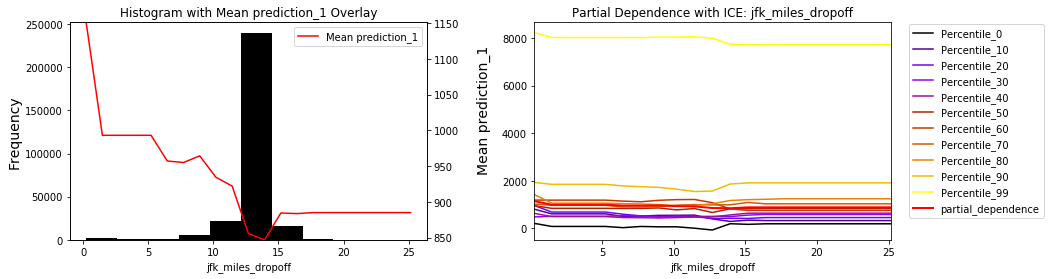

<Figure size 1800x1200 with 0 Axes>

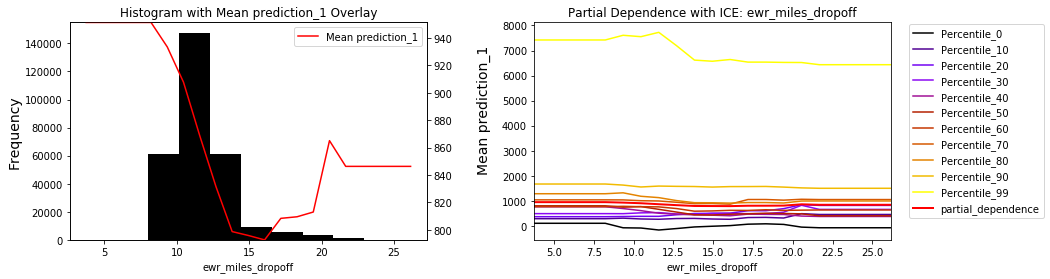

<Figure size 1800x1200 with 0 Axes>

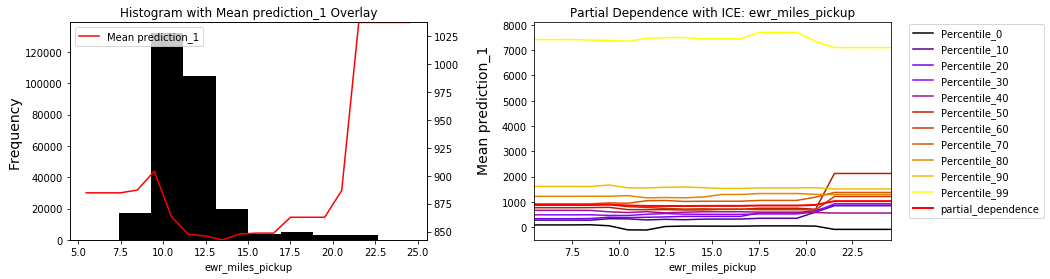

<Figure size 1800x1200 with 0 Axes>

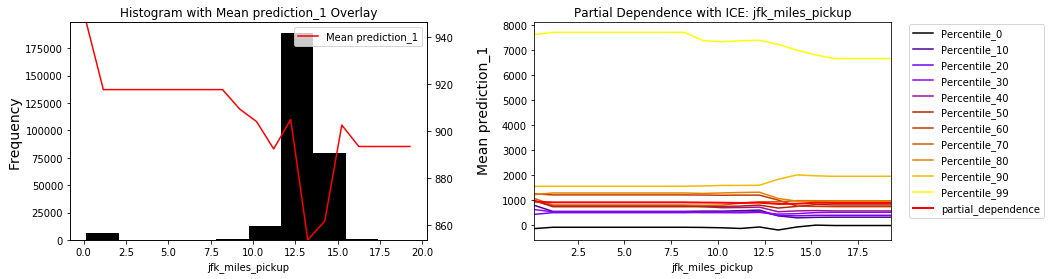

<Figure size 1800x1200 with 0 Axes>

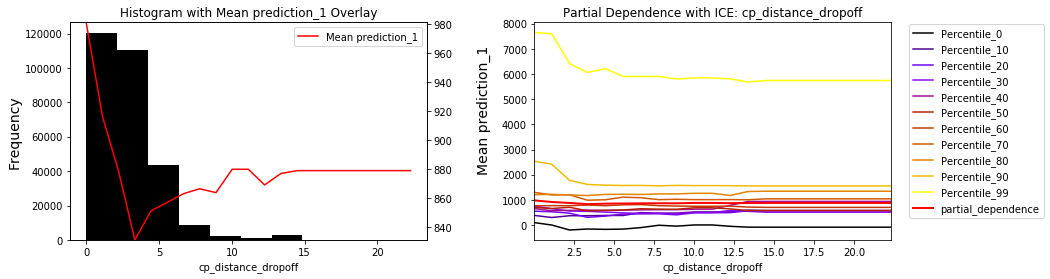

<Figure size 1800x1200 with 0 Axes>

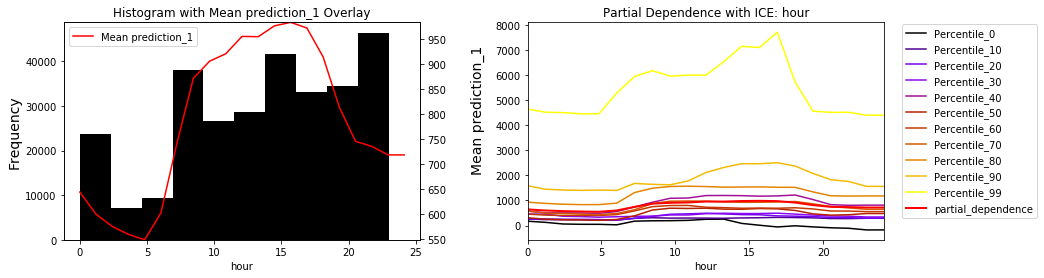

<Figure size 1800x1200 with 0 Axes>

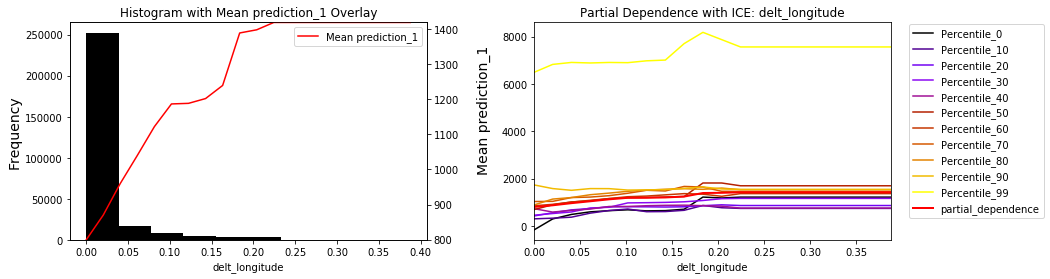

<Figure size 1800x1200 with 0 Axes>

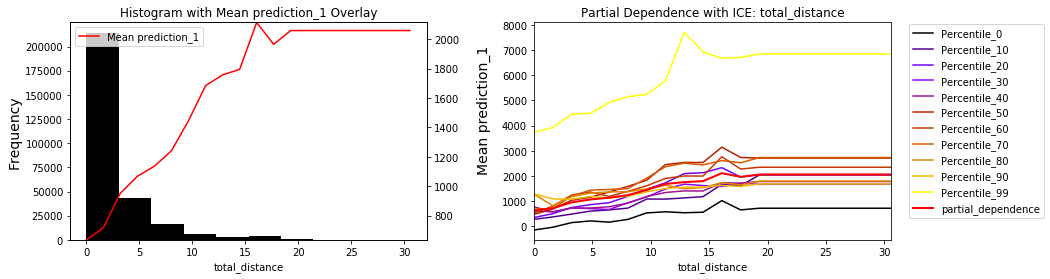

<Figure size 1800x1200 with 0 Axes>

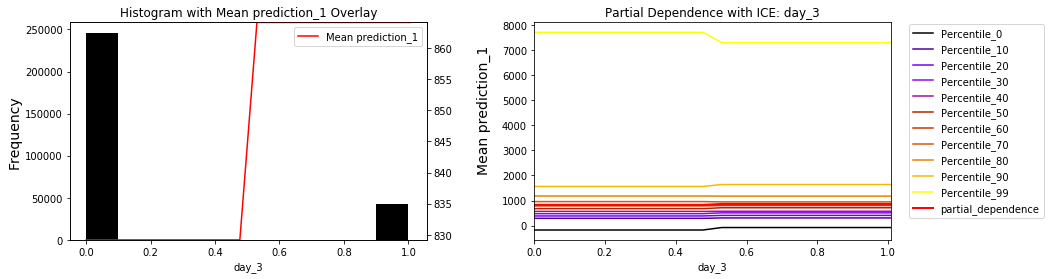

<Figure size 1800x1200 with 0 Axes>

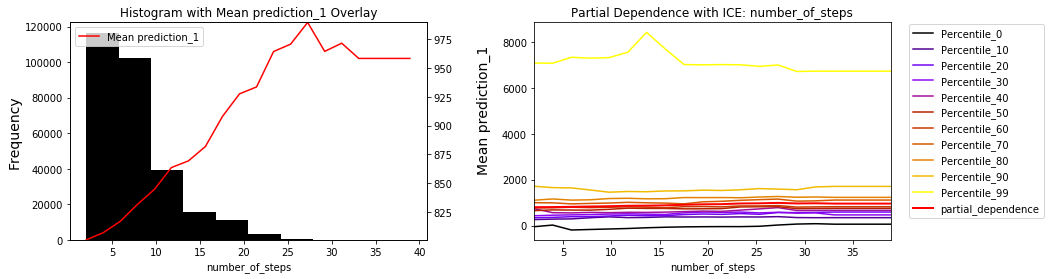

<Figure size 1800x1200 with 0 Axes>

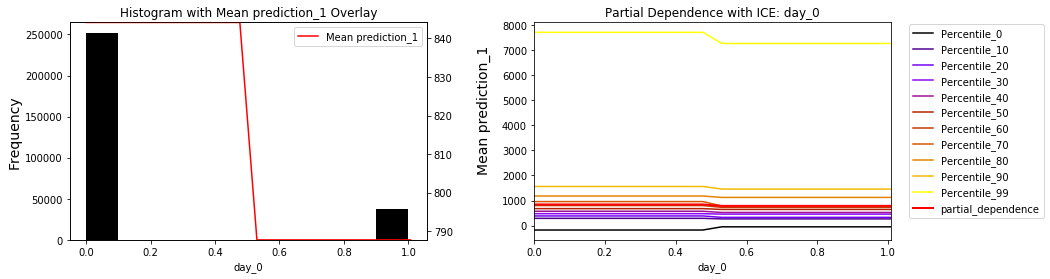

<Figure size 1800x1200 with 0 Axes>

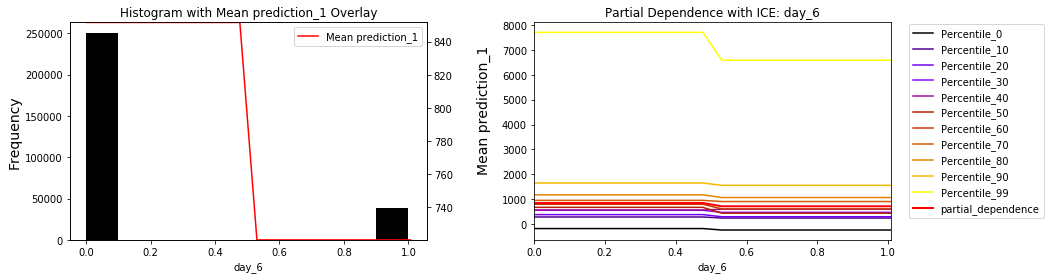

<Figure size 1800x1200 with 0 Axes>

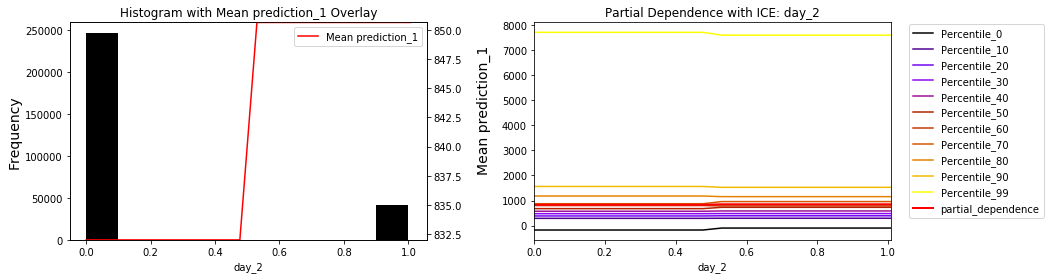

<Figure size 1800x1200 with 0 Axes>

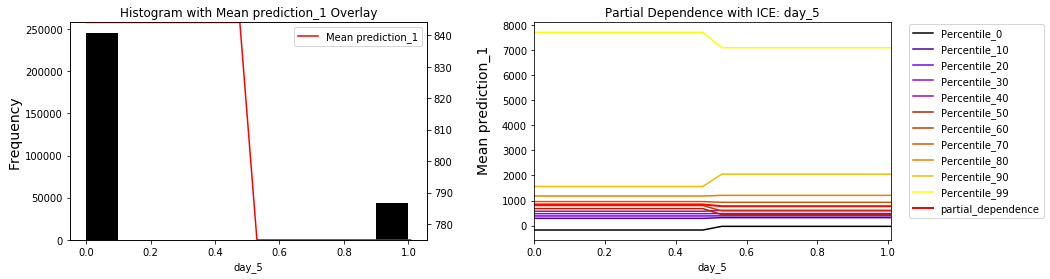

In [307]:
for i in features_to_plot:
    plot_ICE_par(i, 'prediction_1', validation_data, ice_dict)

The plots above sow the expected behavior for the feature selected, PDPs for the taxi duration prediction model and the 14 features. From the PDP, we can see that the largest differences can be seen in the total distance. The longer the total distance is, the longer the trips duration are. And the other features do not show fluctuation on PDP when the value of the features get large or like the categorical feature change from on to other. 

As shown in plot above, other than the PDP line, each line represents some percentile of the taxi duration prediction and visualizes the effect of varying the selected feature value  on the model’s prediction, given all other features remain constant . An ICE plot can highlight the variation in the fitted values across the range of a feature. This suggests where and to what extent heterogeneities might exist. From the plot above, we notice that most of the features follow the same patter and show no interation with each others.

<h4>Surrogate Model.</h4>

Set up graphviz enviornment. 

In [3]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Instead of using a gbm or xgboost model, use a simple decision tree model here.

To run the code, need to install:
    
    graphviz
    pylab
    subprocess

In [17]:
def surrogate_interpret(features, target, data, depth = 5, validation = None, graphviz_display = True, plot_path = 'C:\\Users\\lllll\\Desktop\\Responsible ml', name = 'Kaggle_taxi_xgb'):
    
    from graphviz import Source
    import pylab
    import matplotlib.image as mpimg
    from subprocess import check_call
    %pylab inline
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.tree import export_graphviz
    
    if validation == None:
        
        surrogate = DecisionTreeRegressor(random_state = 0, max_depth = int(depth))
        
        x, y = data[features], data[target]
        scores = cross_validate(surrogate, x, y, cv = 5, scoring = 'neg_root_mean_squared_error', return_train_score = True)
        surrogate.fit(x, y)
        print('Training RMSE for the surrogate model: ', abs(scores['train_score'].mean()), 
              '\nValidation RMSE for the surrogate model: ', abs(scores['test_score'].mean()))
        
    else:
        
        surrogate = DecisionTreeRegressor(random_state = 0, max_depth = int(depth))
        
        x, y = data[features], data[target]
        surrogate.fit(x, y)
        validation_rmse = math.sqrt(mse(surrogate.predict(validation[features]), validation[target]))
        train_rmse = math.sqrt(mse(surrogate.predict(x), y))
        print('Training RMSE for the surrogate model: ', train_rmse,
             '\nValidation RMSE for the surrogate model: ', validation_rmse)
        
    dot_file_path = os.path.join(plot_path, 'surrogate_model_{}.dot'.format(name))
    print('Saving graphviz dot file to: {}'.format(dot_file_path))
    tree_plot = export_graphviz(surrogate, feature_names = features, 
                                class_names = target, out_file = dot_file_path)
    
    png_file_path = os.path.join(plot_path, 'surrogate_model_{}.png'.format(name))
    print('Converting dot file to png and saving to: {}'.format(png_file_path))    
    check_call(['dot', '-Tpng', dot_file_path, '-o', png_file_path])  #  Convert graphviz dot file to png file for storage
    #display(Image(filename = png_file_path))
    
    if graphviz_display:
    
        return Source.from_file(dot_file_path)
    
    else:
        img = mpimg.imread(png_file_path)
        plt.figure(dpi = 800, figsize = (20, 20))
        imgplot = plt.imshow(img)
        plt.show()

Populating the interactive namespace from numpy and matplotlib
Training RMSE for the surrogate model:  260.5277328562762 
Validation RMSE for the surrogate model:  261.2862524775149
Saving graphviz dot file to: C:\Users\lllll\Desktop\Responsible ml\surrogate_model_Kaggle_taxi_xgb.dot
Converting dot file to png and saving to: C:\Users\lllll\Desktop\Responsible ml\surrogate_model_Kaggle_taxi_xgb.png


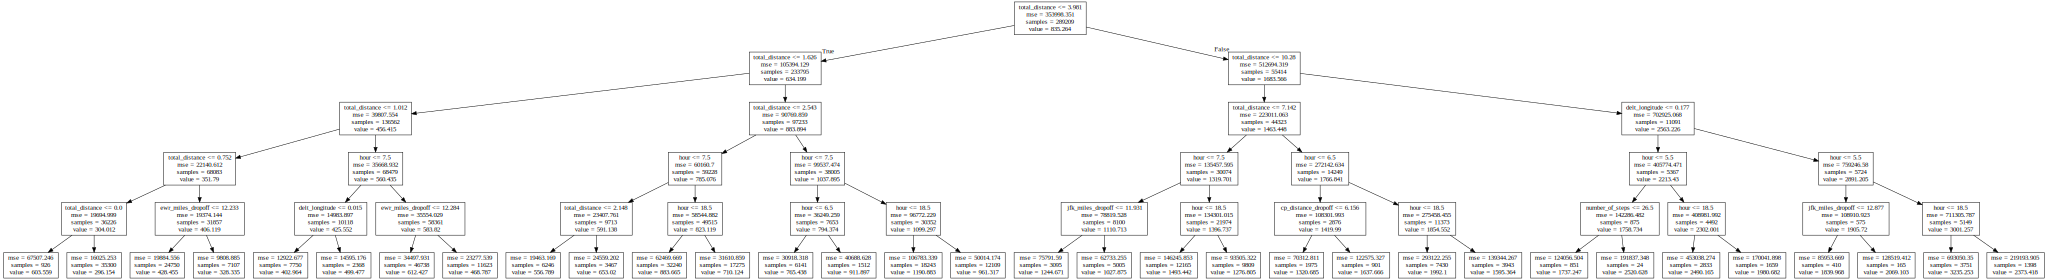

In [18]:
surrogate_interpret(features_to_plot, 'prediction_1', validation_data)

Although this is a simple surrogate model, due to the size of the data and the complexity of the problem, the tree model is still a little bit huge. But this still provides us an idea of how the model predicts.

From the surrogate model we get,we could notice that the model do not perform well on the trip longer trips since the mean trip duration of the data is about 1000. We could notice the high value of MSE for the long trip.

<br>

<h4>Shapley value interpret the model using shap.TreeExplainer</h4>

Initiate shap visualization function.

In [22]:
shap.initjs()

In [23]:
explain = shap.TreeExplainer(gpu_xgb_model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [32]:
import time

#features_to_use = [i for i in sorted_importance_list.keys()][-1:-11]
data_to_use = validation_data[train_feature_list]

start = time.time()
shap_value = explain.shap_values(data_to_use, approximate = True)
end = time.time()

print('Samples: ', len(data_to_use), 'time: ', end - start)

Samples:  289209 time:  21.03569507598877


In [360]:
ave_shap_dict = {}
for i in range(len(train_feature_list)):
    
    ave_shap_dict[train_feature_list[i]] = np.mean(shap_value[:,i])

In [361]:
ave_shap_df = pd.DataFrame(data = {'feature':[i for i in ave_shap_dict.keys()], 'mean_shap_value':[i for i in ave_shap_dict.values()]})
ave_shap_df = ave_shap_df.sort_values(by = 'mean_shap_value', ascending = False)

Complete global shapley value plot.

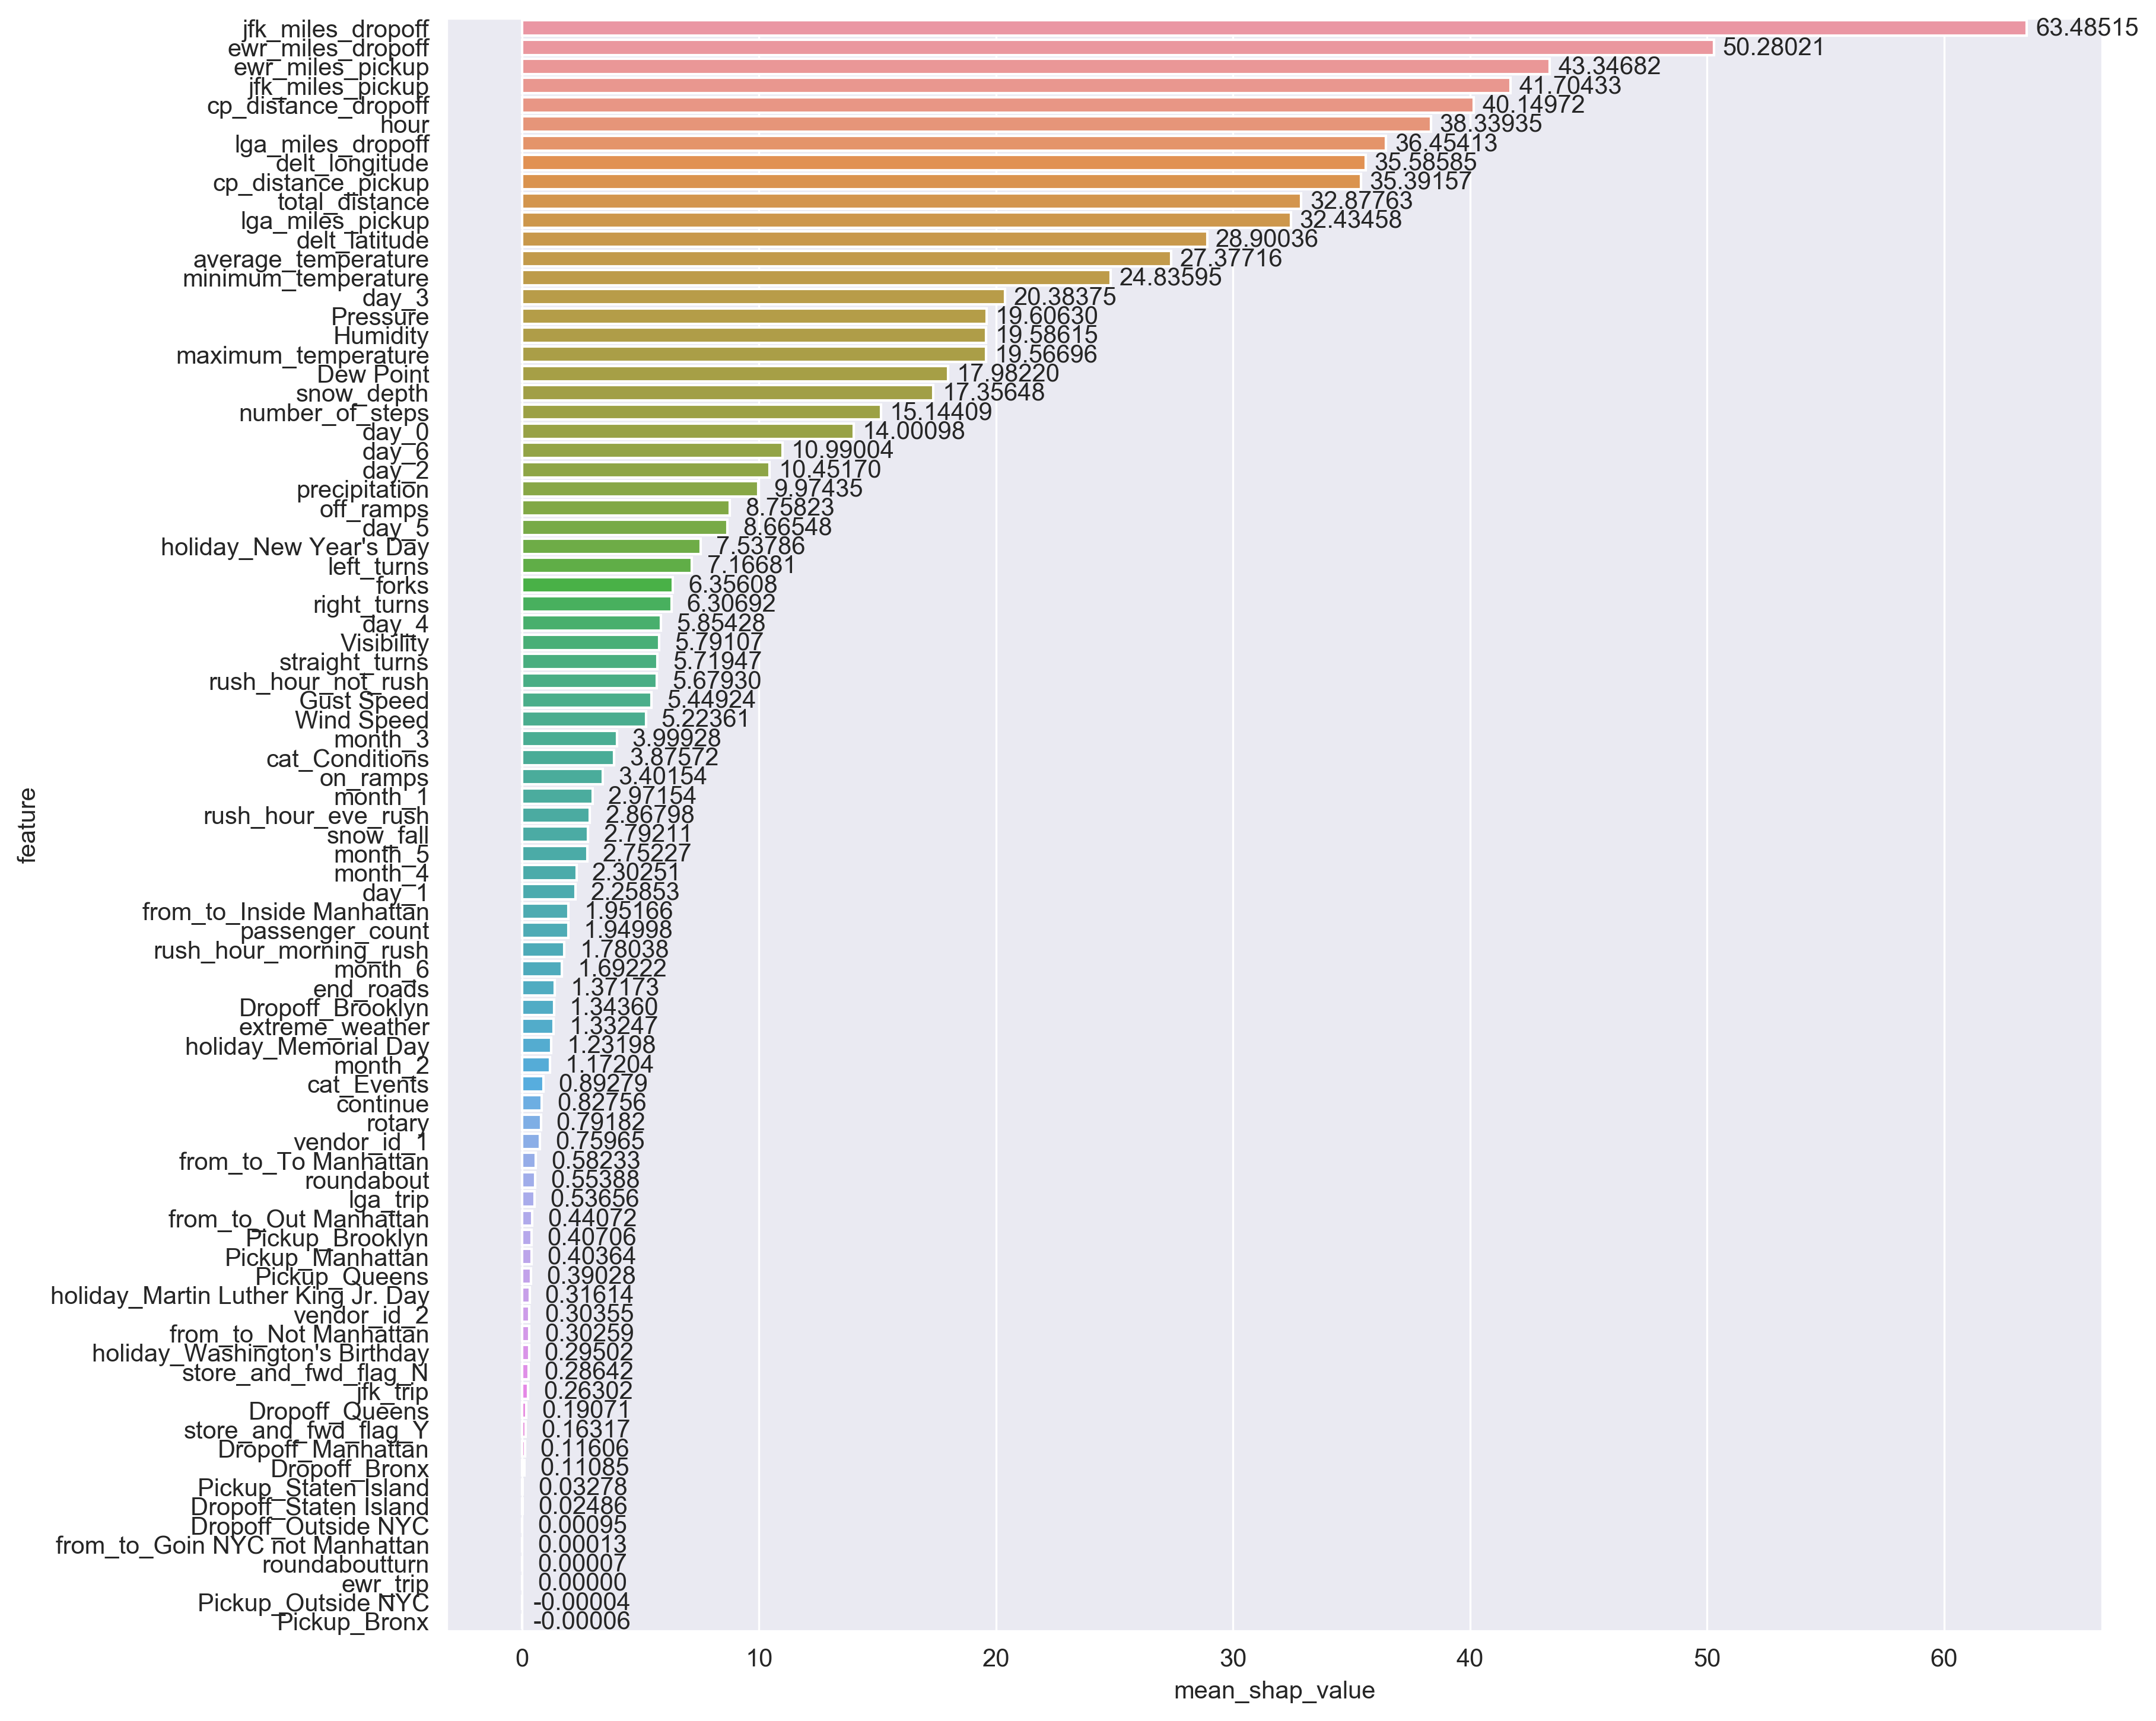

In [362]:
plt.figure(dpi = 300, figsize = (12,12))
sns.set_style('darkgrid')
splot = sns.barplot(y = 'feature', x = 'mean_shap_value', data = ave_shap_df, orient = 'h')
for p in splot.patches:
            width = p.get_width()
            plt.text(np.max(np.array(ave_shap_df['mean_shap_value']))/25 + p.get_width(), p.get_y() + 0.55 * p.get_height(),
                     '{:1.5f}'.format(width),
                     ha='center', va='center')

The plot above show the Global Shapley for each feature in our model. SHAP feature importance measured as the mean absolute Shapley values. As we can see,JFK_miles_dropoff is still the most important one, follow with ewr_miles_dropoff, ewr_miles_pickup, jfk_miles_pickup and so on.

Global Shapley plot.

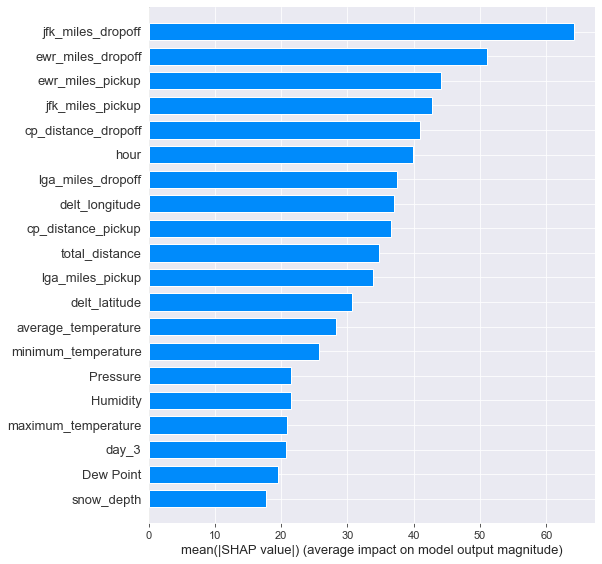

In [363]:
shap.summary_plot(shap_value, data_to_use, plot_type = 'bar')

Compared with the previous figure based on feature importance, it shows slight differences. The feature rank the the top becomes jfk_miles_dropoff, total distance rank lower than the one in feature importance plot.

Feature-wise shapley value.

In [55]:
from IPython.display import clear_output

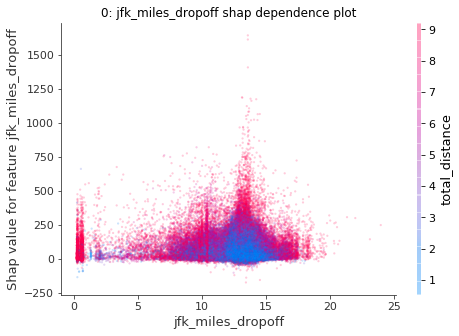

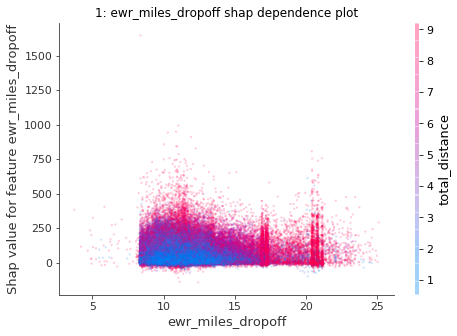

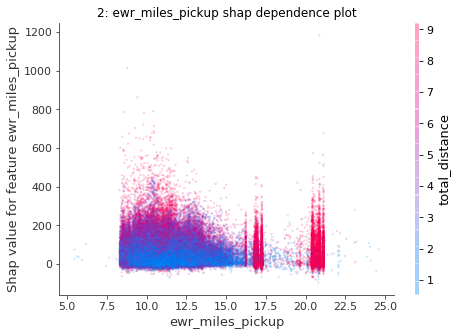

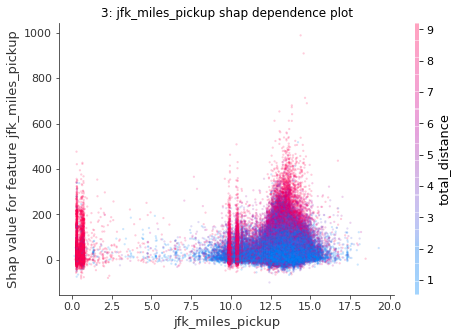

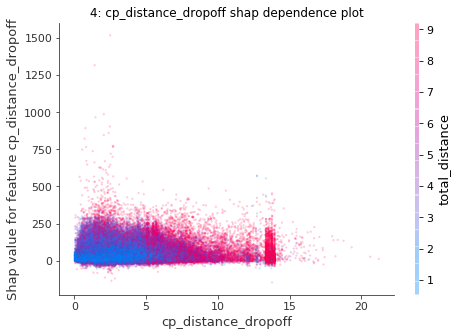

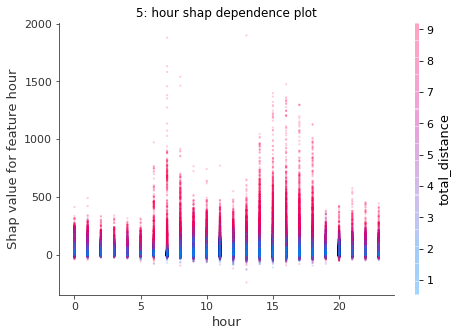

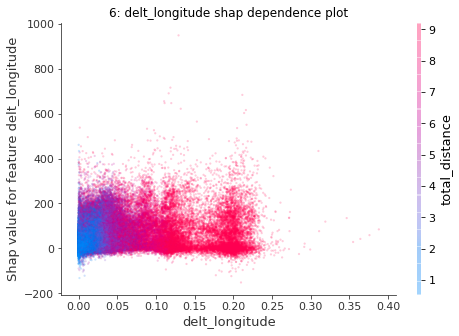

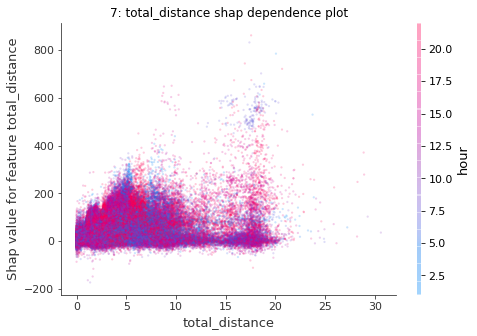

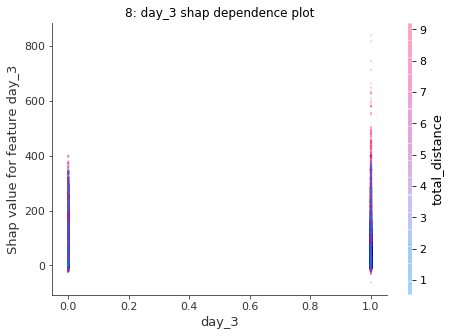

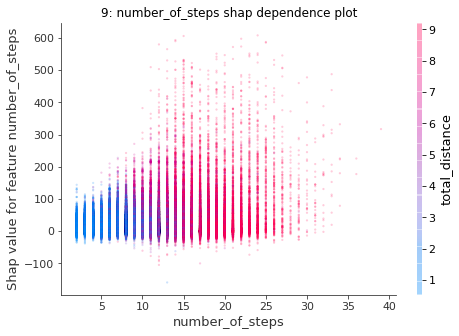

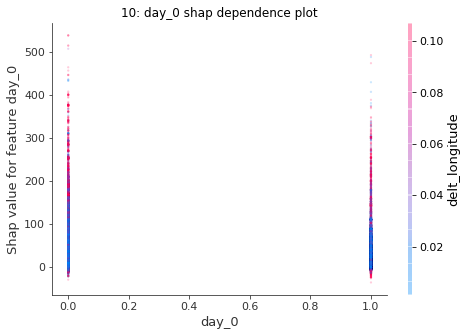

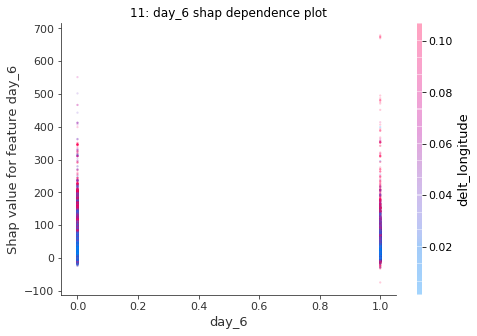

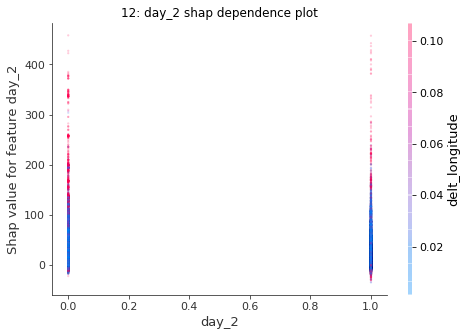

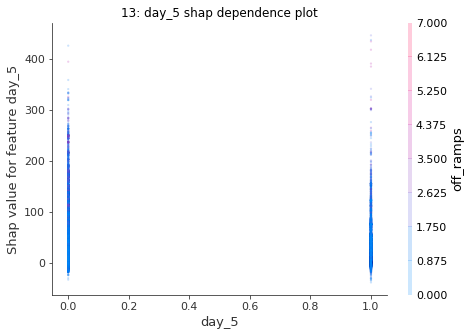

In [70]:
for i, values in enumerate(features_to_plot):
    shap.dependence_plot(values, shap_value, data_to_use, alpha = 0.2, dot_size = 5, show = False)
    plt.title('{}: {} shap dependence plot'.format(i, values))
    plt.ylabel('Shap value for feature {}'.format(values))
    plt.show()


For all the plots above, each plot the y-axix on the left is the SHAP value, the feature on the right is the correlated featrue selected by the algorithm. The red color represent the higher the feature is. From the plot above, we notice that as hour get large(approach the night time) there are longer trip occur with higher shape value. And most of the jfk_mile_dropoff lies between 10-13, and there is also a spike around 0, there also show high shapely value. 

Local (sample-wise) shapley explain.

Random samples to see:

In [75]:
for i in range(0, 15):
    
    random_sample = np.random.randint(0, len(validation_data)+1, 1)
    print('Displaying local shapley explaination for observation {}'.format(random_sample))
    print('Model output: {}'.format(float(validation_data.iloc[random_sample, -1].values)))
    display(shap.force_plot(explain.expected_value, shap_value[random_sample,:], data_to_use.iloc[random_sample,:]))
 

Displaying local shapley explaination for observation [11245]
Model output: 738.430908203125


Displaying local shapley explaination for observation [216483]
Model output: 782.1511840820312


Displaying local shapley explaination for observation [35189]
Model output: 537.7628784179689


Displaying local shapley explaination for observation [202434]
Model output: 1787.722900390625


Displaying local shapley explaination for observation [215390]
Model output: 1747.371337890625


Displaying local shapley explaination for observation [255334]
Model output: 577.3538208007812


Displaying local shapley explaination for observation [52251]
Model output: 2014.96435546875


Displaying local shapley explaination for observation [213486]
Model output: 367.9943237304688


Displaying local shapley explaination for observation [129955]
Model output: 654.49853515625


Displaying local shapley explaination for observation [227800]
Model output: 917.8297729492188


Displaying local shapley explaination for observation [254631]
Model output: 262.45623779296875


Displaying local shapley explaination for observation [58628]
Model output: 545.0355834960939


Displaying local shapley explaination for observation [148568]
Model output: 1724.774169921875


Displaying local shapley explaination for observation [87863]
Model output: 852.0357666015625


Displaying local shapley explaination for observation [115733]
Model output: 291.8211975097656


The plots above explain the contribution of each features on each selected trips.The feature that increase the prediction from base value to model input is shown read, otherwise shown in blue.As we can see from the all the plots above, for the individual trip the features that contribute most are mostly jfk_miles_dropoff, delt_longitude,total_distance which are mostly the features with high global shapeley value
<br>
<br>

ICE and partial dependence plots indicate that the model behaves strange at percentile 0 and 99. Take a look at those samples.

In [102]:
for i in [0, 99]:
    
    print('Displaying local shapley explaination for observation percentile {}'.format(i))
    index = validation_data[validation_data.id == xgb_per_dict[i]].index.values[0]
    print('Model output: {}'.format(float(validation_data.iloc[index, -1])))
    display(shap.force_plot(explain.expected_value, shap_value[index,:], data_to_use.iloc[index, :]))

Displaying local shapley explaination for observation percentile 0
Model output: 0.0


Displaying local shapley explaination for observation percentile 99
Model output: 7704.27294921875


For the 0 percentile sample, we see that delt latitude and delt longitude are very small thus having a huge negative impact on the trip duration. However, we see that the trip has 5 right turns thus the trip still has some valid distance. In the future we might need to consider dropping the delt latitude(longitude) or add more training data that contain trips like this one.

For the 99 percentile sample, we see that cp_distance_dropoff and delt_latitude contributed hugely on the long trip duration. Same as the above sample, we might need to consider adding more training samples or removing delt longitude(latitude).

<h1>Appendix: Modify Submission Data</h1>
<h3>Create Submission File</h3>

<h4>Do not run parts below.</h4>

In [19]:
test_sub = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\sub_modified.csv')

Columns (35,44) have mixed types. Specify dtype option on import or set low_memory=False.


In [20]:
le = LabelEncoder()
for i in ['pickup_neighborhood_name','dropoff_neighborhood_name']:
    
    temp = test_sub[i]
    test_sub['cat_{}'.format(i)] = le.fit_transform(temp)

In [22]:
new_xgb = gpu_xgb_model.predict(test_sub[train_feature_list])

In [23]:
test_sub['trip_duration'] = new_xgb

In [24]:
def convert_0_trip(distance, time, lat, long, pre):
    
    if distance == 0 and time == 0 and lat <= 0.00001 and long <= 0.00001:
        
        x = 0
        
    else:
        
        x = pre
    
    return x

test_sub['trip_duration_1'] = test_sub.apply(lambda x: convert_0_trip(x['total_distance'], x['total_travel_time'], x['delt_latitude'], x['delt_longitude'], x['trip_duration']), axis = 1)

In [26]:
def convert_negative_trip(pre):
    
    if pre < 0:
        
        x = 0
        
    else:
        x = pre
        
    return x
test_sub['trip_duration_1'] = test_sub.apply(lambda x: convert_negative_trip(x['trip_duration']), axis = 1)

In [27]:
def create_sub_file(sub_data, beta, model, feature):
    
    
    
    sub_file = sub_data[['id','trip_duration_1']]
    sub_file = sub_file.rename(columns = {'id':'id','trip_duration_1':'trip_duration'})
    sub_file.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\new_xgb_beta{}.csv'.format(beta), index = None)
    
    with open('C:\\Users\\lllll\\Desktop\\Responsible ml\\xgb_record.txt','a') as xgb_param:
        context = str(str(model.get_params)+'\n'+str(feature)+'\n\n')
        xgb_param.write(context)
        xgb_param.close()

In [28]:
create_sub_file(test_sub, 1, gpu_xgb_model, train_feature_list)

In [20]:
import pickle
import xgboost

In [30]:
pickle.dump(gpu_xgb_model, open('C:\\Users\\lllll\\Desktop\\Responsible ml\\best_gpu_xgb.pkl', "wb"))

In [21]:
gpu_xgb_model = pickle.load(open('C:\\Users\\lllll\\Desktop\\Responsible ml\\best_gpu_xgb.pkl', "rb"))

In [7]:
gpu_xgb_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.07, max_delta_step=0, max_depth=13,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.8, reg_lambda=0.8, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=False, verbosity=2)>

In [345]:
mean_to_fill = []
bounds = [i/10000 for i in range(0, 125, 5)]
for i in range(len(bounds)):
    
    if i != len(bounds) - 1:

        if i == 0:
    
            upper = float(bounds[i+1])
            lower = float(bounds[i])

            temp = train[(train.delt_longitude <= upper) & (train.delt_latitude <= upper)]
            temp_mean = temp[(train.delt_longitude > lower) & (train.delt_latitude > lower)]['trip_duration'].mean()

            mean_to_fill.append(temp_mean)
        
        else:
            
            upper = float(bounds[i+1])
            lower = float(bounds[i])

            temp = train[(train.delt_longitude <= upper) & (train.delt_latitude <= upper)]
            temp_mean = temp[(train.delt_longitude >= lower) & (train.delt_latitude >= lower)]['trip_duration'].mean()

            mean_to_fill.append(temp_mean)
            
    else:
        lower = float(bounds[i])
        
        temp = temp = train[(train.delt_longitude <= 0.0125) & (train.delt_latitude <= 0.0125)]
        temp_mean = temp[(train.delt_longitude >= lower) & (train.delt_latitude >= lower)]['trip_duration'].mean()
        mean_to_fill.append(temp_mean)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<h1>Appendix: Modify Submission Data</h1>
<h2>Create submission data</h2>

Sample submission: Preprocess submission data.

In [35]:
weather = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\modified_weather.csv')
weather = weather.drop(['Unnamed: 0'], axis = 1)

In [10]:
sub = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\sub_modified.csv')
sub

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (35,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id  vendor_id      pickup_datetime  passenger_count  \
0       id3004672          1  2016-06-30 23:59:58                1   
1       id3505355          1  2016-06-30 23:59:53                1   
2       id1217141          1  2016-06-30 23:59:47                1   
3       id2150126          2  2016-06-30 23:59:41                1   
4       id1598245          1  2016-06-30 23:59:33                1   
...           ...        ...                  ...              ...   
625129  id3008929          1  2016-01-01 00:02:52                1   
625130  id3700764          1  2016-01-01 00:01:52                1   
625131  id2568735          1  2016-01-01 00:01:24                2   
625132  id1384355          1  2016-01-01 00:00:28                1   
625133  id0621643          2  2016-01-01 00:00:22                2   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.988129        40.732029         -73.990173   
1             -73.964203        40.679993         -73.959808   
2             -73.997437        40.737583         -73.986160   
3             -73.956070        40.771900         -73.986427   
4             -73.970215        40.761475         -73.961510   
...                  ...              ...                ...   
625129        -74.003464        40.725105         -74.001251   
625130        -74.006363        40.743782         -73.953407   
625131        -73.972267        40.759865         -73.876602   
625132        -73.976501        40.733562         -73.854263   
625133        -73.981850        40.716881         -73.969330   

        dropoff_latitude store_and_fwd_flag  delt_longitude  delt_latitude  \
0              40.756680                  N        0.002045       0.024651   
1              40.655403                  N        0.004395       0.024590   
2              40.729523                  N        0.011276       0.008060   
3              40.730469                  N        0.030357       0.041431   
4              40.755890                  N        0.008705       0.005585   
...                  ...                ...             ...            ...   
625129         40.733643                  N        0.002213       0.008537   
625130         40.782467                  N        0.052956       0.038685   
625131         40.748665                  N        0.095665       0.011200   
625132         40.891788                  N        0.122238       0.158226   
625133         40.769379                  N        0.012520       0.052498   

         distance  jfk_miles_pickup  jfk_miles_dropoff  lga_miles_pickup  \
0        1.704336         12.682374          13.688162          6.802389   
1        1.712358         10.134759           9.597201          8.095343   
2        0.812202         13.296644          12.507671          7.108439   
3        3.272749         12.980454          12.551725          4.503703   
4        0.597601         13.057252          12.459711          5.305564   
...           ...               ...                ...               ...   
625129   0.600434         13.172773          13.338891          7.733841   
625130   3.852897         13.916672          13.399913          7.422183   
625131   5.078957         13.070976           9.034074          5.429556   
625132  12.659995         12.209689          17.739075          6.205435   
625133   3.681598         11.904131          13.374841          7.022583   

        lga_miles_dropoff  ewr_miles_pickup  ewr_miles_dropoff  hour  day  \
0                6.392919         10.213836          10.726963    23    3   
1                9.379773         11.063992          11.520553    23    3   
2                6.783405          9.868407          10.265225    23    3   
3                6.767362         12.795335          10.269417    23    3   
4                4.932596         11.815521          12.080886    23    3   
...                   ...               ...                ...   ...  ...   
625129          

In [37]:
sub['delt_longitude'] = (sub['pickup_longitude'] - sub['dropoff_longitude']).abs()
sub['delt_latitude'] = (sub['pickup_latitude'] - sub['dropoff_latitude']).abs()

In [38]:
geo_dist = lambda x: geopy.distance.distance((x[0], x[1]), (x[2], x[3])).miles

sub_dist = sub[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].values

try_dist = [geo_dist(n) for n in sub_dist]

In [40]:
sub['distance'] = try_dist

In [43]:
jfk = [40.6413111, -73.7781391]
lga = [40.7730135746,  -73.8702298524]
ewr = [40.6895314, -74.17446239999998]

In [44]:
jfk_dist = lambda x: geopy.distance.distance((x[0], x[1]), (jfk[0], jfk[1])).miles

jfk_miles_pickup, jfk_miles_dropoff = [jfk_dist(n) for n in sub[['pickup_latitude','pickup_longitude']].values], [jfk_dist(n) for n in sub[['dropoff_latitude','dropoff_longitude']].values]

In [45]:
lga_dist = lambda x: geopy.distance.distance((x[0], x[1]), (lga[0], lga[1])).miles

lga_miles_pickup, lga_miles_dropoff = [lga_dist(n) for n in sub[['pickup_latitude','pickup_longitude']].values], [lga_dist(n) for n in sub[['dropoff_latitude','dropoff_longitude']].values]

In [46]:
ewr_dist = lambda x: geopy.distance.distance((x[0], x[1]), (ewr[0], ewr[1])).miles

ewr_miles_pickup, ewr_miles_dropoff = [ewr_dist(n) for n in sub[['pickup_latitude','pickup_longitude']].values], [ewr_dist(n) for n in sub[['dropoff_latitude','dropoff_longitude']].values]

In [47]:
sub['jfk_miles_pickup'] = jfk_miles_pickup
sub['jfk_miles_dropoff'] = jfk_miles_dropoff
sub['lga_miles_pickup'] = lga_miles_pickup
sub['lga_miles_dropoff'] = lga_miles_dropoff
sub['ewr_miles_pickup'] = ewr_miles_pickup
sub['ewr_miles_dropoff'] = ewr_miles_dropoff

In [48]:
sub_hour_values = np.array(sub['pickup_datetime'])

sub_filters = lambda x: x[11:13]

sub_hour_values_final = np.array([sub_filters(n) for n in sub_hour_values])

sub['hour'] = sub_hour_values_final

In [49]:
def get_sub_day(data):
    
    day_fun = lambda x: datetime.datetime.strptime(x[0:10], '%Y-%m-%d').weekday()
    
    day_values_final = np.array([day_fun(n) for n in data])
    
    sub['day'] = day_values_final
    
    return sub

if __name__ == '__main__':
    get_sub_day(sub['pickup_datetime'])

In [50]:
date_filter = lambda x: x[0:10]

sub['date'] = np.array([date_filter(n) for n in sub['pickup_datetime']])

In [51]:
sub['Date'] = sub['date']
sub = sub.drop(['date'], axis = 1)

In [52]:
weather

date  maximum temperature  minimum temperature  \
0      1-1-2016                   42                   34   
1      2-1-2016                   40                   32   
2      3-1-2016                   45                   35   
3      4-1-2016                   36                   14   
4      5-1-2016                   29                   11   
..          ...                  ...                  ...   
361  27-12-2016                   60                   40   
362  28-12-2016                   40                   34   
363  29-12-2016                   46                   33   
364  30-12-2016                   40                   33   
365  31-12-2016                   44                   31   

     average temperature  precipitation  snow fall  snow depth        Date  
0                   38.0           0.00      0.000         0.0  2016-01-01  
1                   36.0           0.00      0.000         0.0  2016-01-02  
2                   40.0           0.00      0.000         0.0  2016-01-03  
3                   25.0           0.00      0.000         0.0  2016-01-04  
4                   20.0           0.00      0.000         0.0  2016-01-05  
..                   ...            ...        ...         ...         ...  
361                 50.0           0.00      0.000         0.0  2016-12-27  
362                 37.0           0.00      0.000         0.0  2016-12-28  
363                 39.5           0.39      0.000         0.0  2016-12-29  
364                 36.5           0.01      0.001         0.0  2016-12-30  
365                 37.5           0.00      0.000         0.0  2016-12-31  

[366 rows x 8 columns]

In [53]:
sub = sub.merge(weather, on = 'Date', how = 'left')

In [55]:
month = lambda x: x[5:7]
month_array = np.array([month(n) for n in np.array(sub['pickup_datetime'])])
month_array

sub['month'] = month_array

In [56]:
def sub_airport_trip():
    
    for i in ['jfk','lga','ewr']:
        
        temp_data = np.array(sub[['{}_miles_pickup'.format(i), '{}_miles_dropoff'.format(i)]].values)
        
        airport_filter = lambda x: 1 if (x[0] <= 1.5) or (x[1] <= 1.5) else 0
        
        airport_trip_cat = [airport_filter(n) for n in temp_data]
        
        sub['{}_trip'.format(i)] = airport_trip_cat
        
if __name__ == '__main__':
    sub_airport_trip()

In [57]:
sub['Pickup_borough'] = list(map(bound, sub[['pickup_latitude','pickup_longitude']].values))
sub['Dropoff_borough'] = list(map(bound, sub[['dropoff_latitude','dropoff_longitude']].values))

In [58]:
def central_park_distance(data):
    
    data = list(data)
    
    x = geopy.distance.distance((data[0], data[1]), (40.785091, -73.968285)).miles
    
    return x

sub['cp_distance_pickup'] = list(map(central_park_distance, sub[['pickup_latitude', 'pickup_longitude']].values))
sub['cp_distance_dropoff'] = list(map(central_park_distance, sub[['dropoff_latitude', 'dropoff_longitude']].values))

In [59]:
sub.columns.values

array(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'delt_longitude',
       'delt_latitude', 'distance', 'jfk_miles_pickup',
       'jfk_miles_dropoff', 'lga_miles_pickup', 'lga_miles_dropoff',
       'ewr_miles_pickup', 'ewr_miles_dropoff', 'hour', 'day', 'Date',
       'date', 'maximum temperature', 'minimum temperature',
       'average temperature', 'precipitation', 'snow fall', 'snow depth',
       'month', 'jfk_trip', 'lga_trip', 'ewr_trip', 'Pickup_borough',
       'Dropoff_borough', 'cp_distance_pickup', 'cp_distance_dropoff'],
      dtype=object)

In [62]:
cols_right_order = train2.columns.values
cols_right_order

array(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'delt_longitude', 'delt_latitude', 'distance',
       'speed', 'jfk_miles_pickup', 'jfk_miles_dropoff',
       'lga_miles_pickup', 'lga_miles_dropoff', 'ewr_miles_pickup',
       'ewr_miles_dropoff', 'hour', 'day', 'date', 'maximum temperature',
       'minimum temperature', 'average temperature', 'precipitation',
       'snow fall', 'snow depth', 'month', 'jfk_trip', 'lga_trip',
       'ewr_trip', 'Pickup_borough', 'Dropoff_borough',
       'cp_distance_pickup', 'cp_distance_dropoff', 'cat_vendor_id',
       'cat_store_and_fwd_flag', 'cat_day', 'cat_month', 'cat_jfk_trip',
       'cat_lga_trip', 'cat_ewr_trip', 'cat_Pickup_borough',
       'cat_Dropoff_borough'], dtype=object)

In [63]:
sub = sub.drop(['Date'])

id  vendor_id      pickup_datetime  passenger_count  \
0       id3004672          1  2016-06-30 23:59:58                1   
1       id3505355          1  2016-06-30 23:59:53                1   
2       id1217141          1  2016-06-30 23:59:47                1   
3       id2150126          2  2016-06-30 23:59:41                1   
4       id1598245          1  2016-06-30 23:59:33                1   
...           ...        ...                  ...              ...   
625129  id3008929          1  2016-01-01 00:02:52                1   
625130  id3700764          1  2016-01-01 00:01:52                1   
625131  id2568735          1  2016-01-01 00:01:24                2   
625132  id1384355          1  2016-01-01 00:00:28                1   
625133  id0621643          2  2016-01-01 00:00:22                2   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.988129        40.732029         -73.990173   
1             -73.964203        40.679993         -73.959808   
2             -73.997437        40.737583         -73.986160   
3             -73.956070        40.771900         -73.986427   
4             -73.970215        40.761475         -73.961510   
...                  ...              ...                ...   
625129        -74.003464        40.725105         -74.001251   
625130        -74.006363        40.743782         -73.953407   
625131        -73.972267        40.759865         -73.876602   
625132        -73.976501        40.733562         -73.854263   
625133        -73.981850        40.716881         -73.969330   

        dropoff_latitude store_and_fwd_flag  delt_longitude  delt_latitude  \
0              40.756680                  N        0.002045       0.024651   
1              40.655403                  N        0.004395       0.024590   
2              40.729523                  N        0.011276       0.008060   
3              40.730469                  N        0.030357       0.041431   
4              40.755890                  N        0.008705       0.005585   
...                  ...                ...             ...            ...   
625129         40.733643                  N        0.002213       0.008537   
625130         40.782467                  N        0.052956       0.038685   
625131         40.748665                  N        0.095665       0.011200   
625132         40.891788                  N        0.122238       0.158226   
625133         40.769379                  N        0.012520       0.052498   

         distance  jfk_miles_pickup  jfk_miles_dropoff  lga_miles_pickup  \
0        1.704336         12.682374          13.688162          6.802389   
1        1.712358         10.134759           9.597201          8.095343   
2        0.812202         13.296644          12.507671          7.108439   
3        3.272749         12.980454          12.551725          4.503703   
4        0.597601         13.057252          12.459711          5.305564   
...           ...               ...                ...               ...   
625129   0.600434         13.172773          13.338891          7.733841   
625130   3.852897         13.916672          13.399913          7.422183   
625131   5.078957         13.070976           9.034074          5.429556   
625132  12.659995         12.209689          17.739075          6.205435   
625133   3.681598         11.904131          13.374841          7.022583   

        lga_miles_dropoff  ewr_miles_pickup  ewr_miles_dropoff hour  day  \
0                6.392919         10.213836          10.726963   23    3   
1                9.379773         11.063992          11.520553   23    3   
2                6.783405          9.868407          10.265225   23    3   
3                6.767362         12.795335          10.269417   23    3   
4                4.932596         11.815521          12.080886   23    3   
...                   ...               ...                ...  ...  ...   
625129           7.3924

In [247]:
sub = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\sub_modified.csv')

In [53]:
knyc = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\KNYC_Metars.csv')

date_filter = lambda x: x[0:10]
knyc_date = [date_filter(n) for n in knyc['Time'].values]
knyc['Date'] = knyc_date

year_filter = lambda x: x[0:4]
knyc_year = [year_filter(n) for n in knyc['Time'].values]
knyc['Year'] = knyc_year

knyc = knyc[knyc.Year == '2016']

time_filter = lambda x: str(x[0:13])+':00:00'
sub_time = [time_filter(n) for n in sub['pickup_datetime'].values]
#sub_dropofftime = [time_filter(n) for n in sub['dropoff_datetime'].values]

sub['pickup_time'] = sub_time
#sub['dropoff_time'] = sub_dropofftime

sub = sub.merge(knyc, left_on = 'pickup_time', right_on = 'Time', how = 'left')

sub = sub.drop(['pickup_time'], axis = 1)

try1 = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\combined+table+with+neighborhood+and+boro+information.csv')
try1 = try1[['id','pickup_boro','pickup_neighborhood_name','pickup_neighborhood_code','dropoff_neighborhood_name','dropoff_neighborhood_code']]

sub = sub.merge(try1, on = 'id', how = 'left')

weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']
weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date

sub['extreme_weather'] = sub.Date_x.isin(weather_event).map({True: 1, False: 0})

sub

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cat_cols = ['Events','Conditions','pickup_neighborhood_code','dropoff_neighborhood_code']

for i in cat_cols:
    print(i)
    
    sub[i] = sub[i].astype(str)
    
    sub['cat_{}'.format(i)] = le.fit_transform(sub[i])
    
sub



Events
Conditions
pickup_neighborhood_code
dropoff_neighborhood_code


id  vendor_id      pickup_datetime  passenger_count  \
0       id3004672          1  2016-06-30 23:59:58                1   
1       id3505355          1  2016-06-30 23:59:53                1   
2       id1217141          1  2016-06-30 23:59:47                1   
3       id2150126          2  2016-06-30 23:59:41                1   
4       id1598245          1  2016-06-30 23:59:33                1   
...           ...        ...                  ...              ...   
625129  id3008929          1  2016-01-01 00:02:52                1   
625130  id3700764          1  2016-01-01 00:01:52                1   
625131  id2568735          1  2016-01-01 00:01:24                2   
625132  id1384355          1  2016-01-01 00:00:28                1   
625133  id0621643          2  2016-01-01 00:00:22                2   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.988129        40.732029         -73.990173   
1             -73.964203        40.679993         -73.959808   
2             -73.997437        40.737583         -73.986160   
3             -73.956070        40.771900         -73.986427   
4             -73.970215        40.761475         -73.961510   
...                  ...              ...                ...   
625129        -74.003464        40.725105         -74.001251   
625130        -74.006363        40.743782         -73.953407   
625131        -73.972267        40.759865         -73.876602   
625132        -73.976501        40.733562         -73.854263   
625133        -73.981850        40.716881         -73.969330   

        dropoff_latitude store_and_fwd_flag  delt_longitude  delt_latitude  \
0              40.756680                  N        0.002045       0.024651   
1              40.655403                  N        0.004395       0.024590   
2              40.729523                  N        0.011276       0.008060   
3              40.730469                  N        0.030357       0.041431   
4              40.755890                  N        0.008705       0.005585   
...                  ...                ...             ...            ...   
625129         40.733643                  N        0.002213       0.008537   
625130         40.782467                  N        0.052956       0.038685   
625131         40.748665                  N        0.095665       0.011200   
625132         40.891788                  N        0.122238       0.158226   
625133         40.769379                  N        0.012520       0.052498   

         distance  jfk_miles_pickup  jfk_miles_dropoff  lga_miles_pickup  \
0        1.704336         12.682374          13.688162          6.802389   
1        1.712358         10.134759           9.597201          8.095343   
2        0.812202         13.296644          12.507671          7.108439   
3        3.272749         12.980454          12.551725          4.503703   
4        0.597601         13.057252          12.459711          5.305564   
...           ...               ...                ...               ...   
625129   0.600434         13.172773          13.338891          7.733841   
625130   3.852897         13.916672          13.399913          7.422183   
625131   5.078957         13.070976           9.034074          5.429556   
625132  12.659995         12.209689          17.739075          6.205435   
625133   3.681598         11.904131          13.374841          7.022583   

        lga_miles_dropoff  ewr_miles_pickup  ewr_miles_dropoff  hour  day  \
0                6.392919         10.213836          10.726963    23    3   
1                9.379773         11.063992          11.520553    23    3   
2                6.783405          9.868407          10.265225    23    3   
3                6.767362         12.795335          10.269417    23    3   
4                4.932596         11.815521          12.080886    23    3   
...                   ...               ...                ...   ...  ...   
625129          

In [91]:
def create_date(data):
    
    x = data[0:10]
    return x

sub['Date'] = list(map(create_date, sub['pickup_datetime']))

In [92]:
weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']
weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date

sub['extreme_weather'] = sub.Date.isin(weather_event).map({True: 1, False: 0})

In [97]:
def extreme_weather(data):
    weather_event = ['2016-01-10', '2016-01-13', '2016-01-17', '2016-01-23',
                 '2016-02-05', '2016-02-08', '2016-02-15', '2016-02-16',
                 '2016-02-24', '2016-02-25', '2016-03-14', '2016-03-15',
                 '2016-03-28', '2016-03-29', '2016-04-03', '2016-04-04',
                 '2016-05-30', '2016-06-28']
    
    if data in weather_event:
        x = 1
    else:
        x = 0
        
    return x

sub['extreme_weather'] = list(map(extreme_weather, sub['Date']))
    

In [55]:
modify_list = ['maximum temperature','minimum temperature','average temperature','snow fall','snow depth']
modified_dic = {}
def modified_weather(data):
    
    for i in data.columns.values:
        
        if i in modify_list:
            
            modified_dic[i] = str(i).split(' ')[0] + '_' + str(i).split(' ')[1]
            
        else:
            modified_dic[i] = i
            
    data = data.rename(columns = modified_dic)
    return data
    
sub = modified_weather(sub)

In [57]:
def going_to_manhattan(data):
    
    data = list(data)
    
    if (data[0] != 'Manhattan') & (data[1] == 'Manhattan'):
        
        x = 'To Manhattan'
        
    elif (data[1] != 'Manhattan') & (data[0] == 'Manhattan'):
        
        x = 'Out Manhattan'
        
    elif (data[1] != 'Outside NYC') & (data[0] == 'Outside NYC') & (data[1] != 'Manhattan'):
        
        x = 'Goin NYC not Manhattan'
    
    elif (data[1] == 'Manhattan') & (data[0] == 'Outside NYC'):
        
        x = 'Goin NYC Manhattan'
    
    elif (data[1] == 'Manhattan') & (data[0] == 'Manhattan'):
        
        x = 'Inside Manhattan'
    
    else:
        
        x = 'Not Manhattan'
        
    return x

sub['from_to'] = list(map(going_to_manhattan, sub[['Pickup_borough','Dropoff_borough']].values))

In [58]:
def get_holidays(data):
    
    #data = list(data)

    us_holidays = holidays.UnitedStates()
    
    x = us_holidays.get(data)
    
    return x

sub['holiday'] = list(map(get_holidays, sub['date'].values))

In [59]:
def get_rushhour(data):
    
    if data in range(6,10):
        x = 'morning_rush'
        
    elif data in range(15, 21):
        x = 'eve_rush'
    
    else:
        x = 'not_rush'
    
    return x

sub['rush_hour'] = list(map(get_rushhour, sub['hour'].values))

In [60]:
def create_onehot(categorical, data):
 
    for cat in categorical:
        
        columns_index = {}
        temp = pd.get_dummies(data[cat])
    
        for i in temp.columns.values:

            if (cat == 'Pickup_borough') or (cat == 'Dropoff_borough'):
                columns_index[i] = '{}_{}'.format(cat[0:-8], i)
            
            else:
                columns_index[i] = '{}_{}'.format(cat, i)
                
        temp = temp.rename(columns = columns_index)
        
        data = data.merge(temp, how = 'left', left_index = True, right_index = True)
    
    return data

categorical_list = ['vendor_id','store_and_fwd_flag','day','month','Pickup_borough','Dropoff_borough','from_to','holiday','rush_hour']

sub = create_onehot(categorical_list, sub)

In [248]:
#for i in sub.columns.values:
    
    #if i[0:3] == 'cat':
        #sub = sub.drop([i], axis = 1)

sub['Windchill'] = sub['Windchill'].fillna(0)
sub = sub.fillna('None')

In [25]:
def get_left_turns(data):
        
    x = data.split('|').count('left') + data.split('|').count('slight left') + data.split('|').count('sharp left')
    
    return x

def get_right_turns(data):
    
    
    x = data.split('|').count('right') + data.split('|').count('slight right') + data.split('|').count('sharp right')
    
    return x

def get_straight_turns(data):
    
    
    x = data.split('|').count('straight')
    
    return x

def get_onramp(data):
    
    x = data.split('|').count('on ramp')
    return x

def get_offramp(data):
    
    x = data.split('|').count('off ramp')
    return x

def get_fork(data):
    
    x = data.split('|').count('fork')
    return x

def get_endofroad(data):
    
    x = data.split('|').count('end of road')
    return x

def get_continue(data):
    
    x = data.split('|').count('continue')
    return x

def get_roundabout(data):
    
    x = data.split('|').count('roundabout')
    return x

def get_rotary(data):
    
    x = data.split('|').count('rotary')
    return x

def get_roundaboutturn(data):
    
    x = data.split('|').count('roundabout turn')
    return x

In [24]:
route_api_sub = pd.read_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\fastest_routes_test.csv')
route_api_sub['total_distance'] = route_api_sub['total_distance'] / 1000 / 1.6

In [26]:
route_api_sub['on_ramps'] = list(map(get_onramp, route_api_sub['step_maneuvers']))
route_api_sub['off_ramps'] = list(map(get_offramp, route_api_sub['step_maneuvers']))
route_api_sub['forks'] = list(map(get_fork, route_api_sub['step_maneuvers']))
route_api_sub['end_roads'] = list(map(get_endofroad, route_api_sub['step_maneuvers']))
route_api_sub['continue'] = list(map(get_continue, route_api_sub['step_maneuvers']))
route_api_sub['roundabout'] = list(map(get_roundabout, route_api_sub['step_maneuvers']))
route_api_sub['rotary'] = list(map(get_rotary, route_api_sub['step_maneuvers']))
route_api_sub['roundaboutturn'] = list(map(get_roundaboutturn, route_api_sub['step_maneuvers']))

route_api_sub['left_turns'] = list(map(get_left_turns, route_api_sub['step_direction']))
route_api_sub['right_turns'] = list(map(get_right_turns, route_api_sub['step_direction']))
route_api_sub['straight_turns'] = list(map(get_straight_turns, route_api_sub['step_direction']))

In [249]:
none_list = []
for i in feature_list:
    
    if 'None' in sub[i].values:
        print(i)
        none_list.append(i)
        
for i in none_list:
    
    sub[i] = sub[i].replace('None', 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


Humidity
Pressure
Dew Point
Visibility
Wind Speed
Gust Speed


In [34]:
sub = sub.merge(route_api_sub[['id','total_distance','total_travel_time','number_of_steps','left_turns',
                                   'right_turns','straight_turns','on_ramps','off_ramps','forks','end_roads','continue'
                                   ,'roundabout','rotary','roundaboutturn']], on = 'id', how = 'left')

In [285]:
sub.to_csv('C:\\Users\\lllll\\Desktop\\Responsible ml\\sub_modified.csv', index = None)

In [286]:
del sub